In [1]:
#coding:utf-8
#稳定函数模块
from tqdm import tqdm
import numpy as np
import pandas as pd
import time
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score,classification_report,f1_score,accuracy_score,recall_score
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp,space_eval,rand,Trials,partial,STATUS_OK

#二值化处理，传入np.array或list，输出二值化后的同类型数据
def binarize(result,threshold=0.5):
    for i in range(len(result)):
        if result[i]>threshold:
            result[i]=1
        else:
            result[i]=0
    return result

#计算F1score的函数,传入预测结果和正确的结果，返回F1_score
def cal_f1(result_valid,lb_valid):
    TP,FP,FN = 0,0,0
    for i in range(len(lb_valid)):
        if result_valid[i] ==1 and lb_valid[i] == 1:
            TP +=1
        if result_valid[i]==1 and lb_valid[i]==0:
            FP +=1
        if result_valid[i] == 0 and lb_valid[i]==1:
            FN +=1
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*precision*recall/(precision + recall)
    #print('precision:',precision)
    #print('recall:',recall)
    return F1

#测试集预测,传入lgb_model、sid以及测试集特征，直接生成csv文件并返回True
#如果需要二值化，则多一条binarize = True
def predict(bst,sid,test,outputfile,binarized = False,threshold=0.5):
    result = bst.predict(test)
    if binarized==True:
        result = binarize(result,threshold)
    #进行拼接并生成最终文件
    result = pd.DataFrame(result)
    final = pd.concat([sid,result], axis=1, join='outer')
    final.columns = ['sid','label']
    print(final['label'].value_counts())
    final.to_csv(outputfile,index = None)
    return True

#lgb训练log作图，传入metric_dict，自动生成图像，并在最后一个点处标记数据
def picture_lgb_loss(metric_dict):
    plt.figure(figsize=(8, 6))
    plt.plot(metric_dict['valid_0']['auc'])
    plt.plot(metric_dict['valid_0']['binary_logloss'])
    plt.plot(metric_dict['valid_0']['binary_error'])
    plt.title('lgb-naive log')
    plt.ylabel('Loss&AUC#Error')
    plt.xlabel('Epoch')
    plt.legend(['val_auc','val_loss','val_error'], loc='right')
    
    final = len(metric_dict['valid_0']['auc'])

    plt.text(final, metric_dict['valid_0']['auc'][final-1] ,"final:"+str(metric_dict['valid_0']['auc'][final-1])
             , ha='center', va='bottom', fontsize=10)
    plt.text(final, metric_dict['valid_0']['binary_logloss'][final-1] ,"final:"+str(metric_dict['valid_0']['binary_logloss'][final-1])
             , ha='center', va='bottom', fontsize=10)
    plt.text(final, metric_dict['valid_0']['binary_error'][final-1] ,"final:"+str(metric_dict['valid_0']['binary_error'][final-1])
             , ha='center', va='bottom', fontsize=10)
    plt.show()
    
# 创建训练集，验证集，本地训练集
def create_train_valid_test(train_x,train_y,untrain_size=0.1,random=2019):
    #train_x，总训练特征，dataframe
    #train_y，总训练标签，Series
    #untrain_size，非训练集比例
    #random，随机划分的种子，种子相同即随机划分相同
    #划分训练集和非训练集
    train_X,valid_X, train_Y, valid_Y = train_test_split(train_x,
                                                   train_y,
                                                   test_size = untrain_size,
                                                   random_state = random)
    return train_X,valid_X,train_Y, valid_Y

# 创建可训练的lgb数据集
def create_lgb_dataset(data,categorical_feature=None,free_raw_data=True):
    # list of dataframe，格式：[train_X,valid_X,train_Y,valid_Y]
    # categorical_feature：哪些特征要被视为分类特征；注意使用，分类特征和数值特征的处理方法不同
    # free_raw_data：是否释放原始数据；当需要使用分类特征时，必须为False
    if categorical_feature != None:
        free_raw_data=False
    train_data = lgb.Dataset(data[0],data[2],categorical_feature=categorical_feature,free_raw_data=free_raw_data)
    valid_data = lgb.Dataset(data[1],data[3],categorical_feature=categorical_feature,free_raw_data=free_raw_data)
    #返回可训练的训练集与验证集
    return train_data,valid_data
    
def show_metric_score(y_true,y_pred,threshold=0.5):
    auc = roc_auc_score(y_true,y_pred)
    y_p = y_pred.copy()
    y_p = binarize(y_p,threshold)
    macro_f1 = f1_score(y_true,y_p,average='macro')
    peter_f1 = cal_f1(y_true,y_p)
    recall = recall_score(y_true,y_p)
    acc = accuracy_score(y_true,y_p)
    metric_score = {
        'auc':auc,
        'macro_f1':macro_f1,
        'peter_f1':peter_f1,
        'recall':recall,
        'acc':acc
    }
    for score_key in metric_score:
        print(score_key+":",metric_score[score_key])
    return metric_score

def lgb_kfold_cv(params,train_x,train_y,test,kfold=5,cate_cols='auto'):
    '''
    params:lgb训练参数字典
    train_x:训练集特征，需去除sid和label
    train_y:训练集对应的label
    test:测试集特征，需去除sid和label(-1)
    '''
    #增加随机性
    #params['seed']=round(time.time())
    free_raw = True
    if cate_cols != 'auto':
        free_raw = False
    train_pred = np.zeros(train_x.shape[0])
    test_pred = np.zeros(test.shape[0]) 
    skf=StratifiedKFold(n_splits=kfold,shuffle=False,random_state=2019)
    feature_importance_df = pd.DataFrame()
    val_auc = []
    val_macro_f1 = []
    val_peter_f1 = []
    val_recall = []
    val_acc = []
    feature_importance_df = pd.DataFrame()
    for fold,(train_fold,valid_fold) in enumerate(skf.split(train_x,train_y)):
        train_data = lgb.Dataset(pd.DataFrame(train_x[train_fold],columns=features),train_y[train_fold],categorical_feature=cate_cols,free_raw_data=free_raw)
        valid_data = lgb.Dataset(pd.DataFrame(train_x[valid_fold],columns=features),train_y[valid_fold],categorical_feature=cate_cols,free_raw_data=free_raw)
        bst = lgb.train(params, train_data, num_boost_round=10000, 
                        valid_sets=valid_data, verbose_eval=100,
                        early_stopping_rounds=200,feval=lgb_f1)
        train_pred[valid_fold] += bst.predict(train_x[valid_fold])
        metric_score = show_metric_score(train_y[valid_fold],train_pred[valid_fold])
        val_auc.append(metric_score['auc'])
        val_macro_f1.append(metric_score['macro_f1'])
        val_peter_f1.append(metric_score['peter_f1'])
        val_recall.append(metric_score['recall'])
        val_acc.append(metric_score['acc'])
        test_pred += bst.predict(test)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = pd.Series(features)
        fold_importance_df["importance"] = pd.Series(bst.feature_importance(importance_type='gain'))
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Mean val_auc:{0} Mean val_auc:{1}'.format(np.mean(val_auc),np.std(val_auc)))
    print('Mean val_macro_f1:{0} Mean val_macro_f1 std:{1}'.format(np.mean(val_macro_f1),np.std(val_macro_f1)))
    print('Mean val_peter_f1:{0} Mean val_peter_f1 std:{1}'.format(np.mean(val_peter_f1),np.std(val_peter_f1)))
    print('Mean val_recall:{0} Mean val_recall std:{1}'.format(np.mean(val_recall),np.std(val_recall)))
    print('Mean val_acc:{0} Mean val_acc std:{1}'.format(np.mean(val_acc),np.std(val_acc)))
    all_metric_score = show_metric_score(train_y,train_pred)
    test_pred/=5
    
    # 打印特征重要度
    cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False).index)
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
    plt.figure(figsize=(14,26))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
    plt.title('LightGBM Features (averaged over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances.png')
    
    return all_metric_score,test_pred

#搜索超参数用
def lgb_cv_wrapper(params):
    all_metric_score,_ = lgb_kfold_cv(params,np.array(train_x.drop(['sid','label'],axis=1)),train_y,np.array(test.drop(['sid','label'],axis=1)))
    return -(all_metric_score['macro_f1']+all_metric_score['peter_f1'])/2

#可用于early_stop
def lgb_f1(pred, dt):
    score = f1_score(np.round(pred),dt.get_label(),average='macro')
    return 'f1', score, True
    
feature_path = 'feature/'
model_path = 'model/'

In [5]:
data = pd.read_feather("data_baseline_feature.bin",use_threads=12)

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
 
y_true = [0, 1, 1, 0, 1, 0,1,1,0,0,0,1,0,0,1,0,1]
y_pred = [1, 1, 1, 0, 0, 1,0,1,0,1,1,0,0,0,0,1,1]
 
p = precision_score(y_true, y_pred, average='binary')
r = recall_score(y_true, y_pred, average='binary')

f1score = f1_score(y_true, y_pred)


print(f1score)
print(cal_f1(y_true,y_pred))
print(cal_f1(y_pred,y_true))

0.47058823529411764
0.47058823529411764
0.47058823529411764


In [6]:
null_value_stats = data.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Fusion_attr_model_ratio              189
Fusion_attr_ratio_osv              14118
Fusion_attr_adunitshowid_ratio       189
count_city                         16660
count_ver                         351016
ratio_count                          189
ratio                                189
Fusion_attr_model_osv              13929
count_osv                          13929
Fusion_attr_make_osv               13929
Fusion_attr_make_ratio               189
dtype: int64

In [7]:
data = data.replace([np.inf,-np.inf],np.nan)

In [8]:
data.columns

Index(['var_adunitshowid_h', 'count_model', 'city', 'var_ver_h', 'osv',
       'count_make', 'mean_model_ratio', 'machine', 'count_mediashowid',
       'var_make_w',
       ...
       'lan', 'pkgname', 'var_adunitshowid_ratio', 'day', 'count_pkgname',
       'make', 'mean_ver_w', 'openudidmd5', 'mean_adunitshowid_h', 'label'],
      dtype='object', length=103)

In [6]:
corr_ft = ['h^2_w_ratio', 'w^2_h_ratio','screen_area','creative_dpi_count', 'adunitshowid_count_ip', 'mediashowid_count_ip', 'apptype_count_ip', 'model_count_ip', 'model_count_adidmd5', 'model_count_macmd5', 'make_count_ip', 'make_count_adidmd5', 'make_count_macmd5', 'osv_count_ip', 'osv_count_adidmd5', 'osv_count_macmd5', 'pkgname_count_ip', 'pkgname_count_macmd5', 'reqrealip_count_ip', 'ver_count_ip', 'ver_count_adidmd5', 'ver_count_macmd5', 'adunitshowid_mean_h', 'adunitshowid_mean_h_w_ratio', 'adunitshowid_max_screen_area', 'adunitshowid_mean_screen_area', 'adunitshowid_var_nginxtime-begin_time', 'mediashowid_max_h', 'mediashowid_mean_h', 'mediashowid_var_h', 'mediashowid_max_h_w_ratio', 'mediashowid_mean_h_w_ratio', 'mediashowid_var_h_w_ratio', 'mediashowid_max_w_h_ratio', 'mediashowid_mean_screen_area', 'mediashowid_var_screen_area', 'mediashowid_var_nginxtime-begin_time', 'apptype_mean_h', 'apptype_mean_h_w_ratio', 'apptype_max_w_h_ratio', 'apptype_mean_w_h_ratio', 'apptype_var_w_h_ratio', 'apptype_mean_screen_area', 'apptype_var_screen_area', 'apptype_var_nginxtime-begin_time', 'model_var_w_h_ratio', 'model_max_screen_area', 'model_mean_screen_area', 'model_var_nginxtime-begin_time', 'make_mean_h_w_ratio', 'make_max_screen_area', 'make_mean_screen_area', 'make_var_nginxtime-begin_time', 'osv_var_h_w_ratio', 'osv_max_screen_area', 'osv_mean_screen_area', 'osv_var_nginxtime-begin_time', 'pkgname_var_h', 'pkgname_max_h_w_ratio', 'pkgname_mean_h_w_ratio', 'pkgname_var_h_w_ratio', 'pkgname_mean_w_h_ratio', 'pkgname_max_screen_area', 'pkgname_mean_screen_area', 'pkgname_var_screen_area', 'reqrealip_max_h', 'reqrealip_mean_h', 'reqrealip_max_h_w_ratio', 'reqrealip_mean_h_w_ratio', 'reqrealip_var_h_w_ratio', 'reqrealip_max_w_h_ratio', 'reqrealip_mean_w_h_ratio', 'reqrealip_var_w_h_ratio', 'reqrealip_max_screen_area', 'reqrealip_mean_screen_area', 'reqrealip_var_screen_area', 'ver_var_h', 'ver_var_h_w_ratio', 'ver_max_w_h_ratio', 'ver_var_w_h_ratio', 'ver_mean_screen_area', 'ver_var_screen_area', 'ver_var_nginxtime-begin_time', 'adunitshowid_var_hour', 'mediashowid_mean_period', 'mediashowid_var_period', 'mediashowid_mean_hour', 'mediashowid_var_hour', 'apptype_mean_period', 'apptype_var_period', 'apptype_var_hour', 'osv_var_hour', 'pkgname_var_hour', 'reqrealip_var_hour']

In [7]:
drift_ft = ['ip','adidmd5','imeimd5','macmd5']
time_ft = ['period','hour','minute']
location_ft = ['city','province']

In [8]:
# delete bad ft
data = data.drop(drift_ft+corr_ft,axis=1)

In [9]:
train_x = data[:1000000]
train_y=train_x['label'].values
test=data[-100000:].reset_index(drop=True)
del data
gc.collect()
features = [col for col in train_x.columns if col not in ['sid', 'label']]

In [ ]:
cate_cols = ['adidmd5', 'adunitshowid', 'apptype', 'carrier', 'city', 'dvctype', 
       'imeimd5', 'ip',  'lan', 'macmd5', 'make', 'mediashowid',
       'model', 'ntt', 'osv', 'pkgname',  'province', 'reqrealip',
       'ver',  
       'creative_dpi', 'hour', 'minute', 'period', 
       'osv_summary']

In [48]:
result

{'var_adunitshowid_h': '4.20903912e+05',
 'count_model': '1.07994474e+06',
 'city': '4.63272967e+05',
 'var_ver_h': '1.39528038e+05\n',
 'osv': '3.43434439e+05',
 'count_make': '1.48451755e+06',
 'mean_model_ratio': '6.38744856e+05',
 'machine': '4.62859088e+02\n',
 'count_mediashowid': '5.17563082e+05',
 'var_make_w': '5.08198492e+05',
 'Fusion_attr_model_ratio': '3.11274667e+05',
 'reqrealip2': '3.19103826e+05\n',
 'Fusion_attr_ratio_osv': '6.20255468e+06',
 'hour': '9.13643216e+05',
 'w': '2.15812531e+06',
 'big_model': '6.16753216e+04\n',
 'adunitshowid': '5.59267374e+04',
 'var_model_w': '5.71171165e+04',
 'count_adidmd5': '4.24124514e+04',
 'var_make_h': '3.63287047e+06\n',
 'count_os': '5.43120090e+05',
 'w_count': '1.65607382e+05',
 'count_reqrealip2': '3.58938777e+05',
 'adidmd5': '1.00401579e+06\n',
 'var_adunitshowid_w': '7.30219635e+04',
 'count_adunitshowid': '1.05812170e+07',
 'ver': '1.24686632e+06',
 'Fusion_attr_adunitshowid_ratio': '3.41955413e+05\n',
 'var_make_ratio

In [29]:
result

In [11]:
# 用于特征工程的统一参数
params = {
    'learning_rate': 0.05,
    'boosting_type': 'goss',
    'objective': 'binary',
    'metric': ['binary_error','auc'],
    #'first_metric_only':True,
    'feature_fraction': 1.0,
    #'bagging_fraction':0.8,
    #'bagging_freq':3,
    'num_leaves': 31,
    'verbose': -1,
    'seed':2019
    }
best_params_1 = {
    'boosting_type': 'goss',
    'objective': 'binary',
    'metric': ['binary_error','auc'],
    'feature_fraction': 0.7, 
    'learning_rate': 0.05, 
    'max_depth': -1, 
    'num_leaves': 1023, 
    'reg_alpha': 1, 
    'reg_lambda': 5,
    'verbose': -1,
    'seed':2019
}
best_params_2 = {
    'boosting_type': 'goss',
    'objective': 'binary',
    'metric': ['binary_error','auc'],
    #'first_metric_only':True,
    'feature_fraction': 0.6, 
    'learning_rate': 0.04, 
    'max_depth': -1, 
    'num_leaves': 127, 
    'reg_alpha': 1.65, 
    'reg_lambda': 0.6,
    'verbose': -1,
    'seed':2019
}

In [22]:
train_x['sid']

KeyError: 'sid'

In [23]:
%time metric_score,test_pred = lgb_kfold_cv(best_params_1,np.array(train_x),train_y,np.array(test))

ValueError: Shape of passed values is (799999, 103), indices imply (799999, 102)

In [9]:
#参数搜索空间
space = {
    # uniform 连续分布
    'learning_rate': hp.uniform('learning_rate',0.01,0.1),
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['binary_error','auc'],
    #'first_metric_only':True,
    'feature_fraction': hp.uniform('feature_fraction',0,1),
    'max_depth': -1,
    'bagging_fraction':hp.uniform('bagging_fraction',0,1),
    # choice 离散选择
    'bagging_freq':hp.choice('bagging_freq',[1,3,5]),
    'num_leaves': hp.choice('num_leaves',[31,127,511,1023]),
    'reg_alpha': hp.uniform('reg_alpha',0.1,5),
    'reg_lambda': hp.uniform('reg_lambda',0.1,5),
    'verbose': 0,
    'seed':2019
}


Training until validation scores don't improve for 200 rounds.                                                               
[100]	valid_0's binary_error: 0.0623297	valid_0's auc: 0.985317                                                              
[200]	valid_0's binary_error: 0.0631597	valid_0's auc: 0.985167                                                              
[300]	valid_0's binary_error: 0.0636297	valid_0's auc: 0.98488                                                               
Early stopping, best iteration is:                                                                                           
[106]	valid_0's binary_error: 0.0623847	valid_0's auc: 0.985326
auc:                                                                                                                         
0.9853255884565166                                                                                                           
macro_f1:                                             

macro_f1:                                                                                                                    
0.9376641806760264                                                                                                           
peter_f1:                                                                                                                    
0.9349198462302885                                                                                                           
recall:                                                                                                                      
0.9254185692541856                                                                                                           
acc:                                                                                                                         
0.937785                                                                                                              

[200]	valid_0's binary_error: 0.0637353	valid_0's auc: 0.982158                                                              
[300]	valid_0's binary_error: 0.0631903	valid_0's auc: 0.982838                                                              
[400]	valid_0's binary_error: 0.0630503	valid_0's auc: 0.983124                                                              
[500]	valid_0's binary_error: 0.0629553	valid_0's auc: 0.983256                                                              
Early stopping, best iteration is:                                                                                           
[372]	valid_0's binary_error: 0.0629303	valid_0's auc: 0.983066
auc:                                                                                                                         
0.9830658966765787                                                                                                           
macro_f1:                                             

[100]	valid_0's binary_error: 0.071075	valid_0's auc: 0.978719                                                               
[200]	valid_0's binary_error: 0.064485	valid_0's auc: 0.982386                                                               
[300]	valid_0's binary_error: 0.06227	valid_0's auc: 0.98368                                                                 
[400]	valid_0's binary_error: 0.06146	valid_0's auc: 0.98434                                                                 
[500]	valid_0's binary_error: 0.060905	valid_0's auc: 0.984784                                                               
[600]	valid_0's binary_error: 0.060345	valid_0's auc: 0.985089                                                               
[700]	valid_0's binary_error: 0.060115	valid_0's auc: 0.985318                                                               
[800]	valid_0's binary_error: 0.05974	valid_0's auc: 0.985506                                                         

0.9315600295085569                                                                                                           
recall:                                                                                                                      
0.9217842388096791                                                                                                           
acc:                                                                                                                         
0.934595                                                                                                                     
Training until validation scores don't improve for 200 rounds.                                                               
[100]	valid_0's binary_error: 0.062105	valid_0's auc: 0.984336                                                               
[200]	valid_0's binary_error: 0.062125	valid_0's auc: 0.984443                                                        

[200]	valid_0's binary_error: 0.0663153	valid_0's auc: 0.980111                                                              
[300]	valid_0's binary_error: 0.0656953	valid_0's auc: 0.98072                                                               
[400]	valid_0's binary_error: 0.0655253	valid_0's auc: 0.98101                                                               
[500]	valid_0's binary_error: 0.0654853	valid_0's auc: 0.981155                                                              
Early stopping, best iteration is:                                                                                           
[376]	valid_0's binary_error: 0.0652353	valid_0's auc: 0.980948
auc:                                                                                                                         
0.9809482395303631                                                                                                           
macro_f1:                                             

Mean val_macro_f1:0.9381753109406507 Mean val_macro_f1 std:0.001529908243196157                                              
Mean val_peter_f1:0.9355628462285175 Mean val_peter_f1 std:0.0016461579413246505                                             
Mean val_recall:0.9277916090070437 Mean val_recall std:0.003196915004316695                                                  
Mean val_acc:0.9382859990543736 Mean val_acc std:0.0015232774499742189                                                       
auc:                                                                                                                         
0.9850870244385466                                                                                                           
macro_f1:                                                                                                                    
0.9381757129095397                                                                                                    

acc:                                                                                                                         
0.936938                                                                                                                     
Training until validation scores don't improve for 200 rounds.                                                               
[100]	valid_0's binary_error: 0.0838496	valid_0's auc: 0.971512                                                              
[200]	valid_0's binary_error: 0.0804896	valid_0's auc: 0.973966                                                              
[300]	valid_0's binary_error: 0.0795896	valid_0's auc: 0.975067                                                              
[400]	valid_0's binary_error: 0.0781646	valid_0's auc: 0.975499                                                              
[500]	valid_0's binary_error: 0.0775946	valid_0's auc: 0.976111                                                       

[1300]	valid_0's binary_error: 0.0625947	valid_0's auc: 0.985202                                                             
[1400]	valid_0's binary_error: 0.0626097	valid_0's auc: 0.985217                                                             
[1500]	valid_0's binary_error: 0.0626647	valid_0's auc: 0.98524                                                              
Early stopping, best iteration is:                                                                                           
[1319]	valid_0's binary_error: 0.0624897	valid_0's auc: 0.985205
auc:                                                                                                                         
0.9852050831901269                                                                                                           
macro_f1:                                                                                                                    
0.9373985395960748                                   

auc:                                                                                                                         
0.9847969336105622                                                                                                           
macro_f1:                                                                                                                    
0.9377971426488523                                                                                                           
peter_f1:                                                                                                                    
0.9351711868229163                                                                                                           
recall:                                                                                                                      
0.9274209246749804                                                                                                    

0.9340445409422805                                                                                                           
recall:                                                                                                                      
0.9265057621222005                                                                                                           
acc:                                                                                                                         
0.9368153159234204                                                                                                           
Training until validation scores don't improve for 200 rounds.                                                               
[100]	valid_0's binary_error: 0.064155	valid_0's auc: 0.984615                                                               
[200]	valid_0's binary_error: 0.06299	valid_0's auc: 0.985208                                                         

0.9151389012671235                                                                                                           
recall:                                                                                                                      
0.9037161287650525                                                                                                           
acc:                                                                                                                         
0.919065                                                                                                                     
Training until validation scores don't improve for 200 rounds.                                                               
[100]	valid_0's binary_error: 0.10005	valid_0's auc: 0.963167                                                                
[200]	valid_0's binary_error: 0.0926	valid_0's auc: 0.967803                                                          

Training until validation scores don't improve for 200 rounds.                                                               
[100]	valid_0's binary_error: 0.062695	valid_0's auc: 0.985258                                                               
[200]	valid_0's binary_error: 0.062245	valid_0's auc: 0.985476                                                               
[300]	valid_0's binary_error: 0.0629	valid_0's auc: 0.985363                                                                 
Early stopping, best iteration is:                                                                                           
[189]	valid_0's binary_error: 0.062105	valid_0's auc: 0.985484
auc:                                                                                                                         
0.9854836871091808                                                                                                           
macro_f1:                                              

auc:                                                                                                                         
0.9846645828917747                                                                                                           
macro_f1:                                                                                                                    
0.938916409213786                                                                                                            
peter_f1:                                                                                                                    
0.9364623759539499                                                                                                           
recall:                                                                                                                      
0.9306785118918192                                                                                                    

auc:                                                                                                                         
0.9856758611061417                                                                                                           
macro_f1:                                                                                                                    
0.9378383222557102                                                                                                           
peter_f1:                                                                                                                    
0.93519988303605                                                                                                             
recall:                                                                                                                      
0.9272305573675437                                                                                                    

acc:                                                                                                                         
0.938582                                                                                                                     
Training until validation scores don't improve for 200 rounds.                                                               
[100]	valid_0's binary_error: 0.0662597	valid_0's auc: 0.983055                                                              
[200]	valid_0's binary_error: 0.0660547	valid_0's auc: 0.983296                                                              
[300]	valid_0's binary_error: 0.0666647	valid_0's auc: 0.983023                                                              
Early stopping, best iteration is:                                                                                           
[169]	valid_0's binary_error: 0.0660897	valid_0's auc: 0.983374
auc:                                                  

[200]	valid_0's binary_error: 0.0625	valid_0's auc: 0.985291                                                                 
[300]	valid_0's binary_error: 0.06253	valid_0's auc: 0.985337                                                                
[400]	valid_0's binary_error: 0.06289	valid_0's auc: 0.985217                                                                
Early stopping, best iteration is:                                                                                           
[216]	valid_0's binary_error: 0.062445	valid_0's auc: 0.985315
auc:                                                                                                                         
0.985314607531276                                                                                                            
macro_f1:                                                                                                                    
0.9374317387593667                                     

[200]	valid_0's binary_error: 0.0635053	valid_0's auc: 0.982749                                                              
[300]	valid_0's binary_error: 0.0636603	valid_0's auc: 0.982766                                                              
Early stopping, best iteration is:                                                                                           
[195]	valid_0's binary_error: 0.0633253	valid_0's auc: 0.982746
auc:                                                                                                                         
0.9827462809170545                                                                                                           
macro_f1:                                                                                                                    
0.936575774835817                                                                                                            
peter_f1:                                             

[900]	valid_0's binary_error: 0.0681497	valid_0's auc: 0.982042                                                              
[1000]	valid_0's binary_error: 0.0674497	valid_0's auc: 0.982393                                                             
[1100]	valid_0's binary_error: 0.0669047	valid_0's auc: 0.982692                                                             
[1200]	valid_0's binary_error: 0.0664497	valid_0's auc: 0.982958                                                             
[1300]	valid_0's binary_error: 0.0660597	valid_0's auc: 0.983178                                                             
[1400]	valid_0's binary_error: 0.0657397	valid_0's auc: 0.983371                                                             
[1500]	valid_0's binary_error: 0.0654297	valid_0's auc: 0.983542                                                             
[1600]	valid_0's binary_error: 0.0651947	valid_0's auc: 0.983696                                                      

[600]	valid_0's binary_error: 0.07087	valid_0's auc: 0.980764                                                                
[700]	valid_0's binary_error: 0.069885	valid_0's auc: 0.981369                                                               
[800]	valid_0's binary_error: 0.068985	valid_0's auc: 0.981857                                                               
[900]	valid_0's binary_error: 0.06826	valid_0's auc: 0.982248                                                                
[1000]	valid_0's binary_error: 0.067755	valid_0's auc: 0.982583                                                              
[1100]	valid_0's binary_error: 0.067245	valid_0's auc: 0.982849                                                              
[1200]	valid_0's binary_error: 0.066875	valid_0's auc: 0.983089                                                              
[1300]	valid_0's binary_error: 0.066585	valid_0's auc: 0.983291                                                       

[1400]	valid_0's binary_error: 0.0665853	valid_0's auc: 0.980026                                                             
[1500]	valid_0's binary_error: 0.0662853	valid_0's auc: 0.980235                                                             
[1600]	valid_0's binary_error: 0.0660103	valid_0's auc: 0.98042                                                              
[1700]	valid_0's binary_error: 0.0657953	valid_0's auc: 0.980589                                                             
[1800]	valid_0's binary_error: 0.0656003	valid_0's auc: 0.980731                                                             
[1900]	valid_0's binary_error: 0.0654403	valid_0's auc: 0.98087                                                              
[2000]	valid_0's binary_error: 0.0652753	valid_0's auc: 0.980995                                                             
[2100]	valid_0's binary_error: 0.0652053	valid_0's auc: 0.981102                                                      

G:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



Training until validation scores don't improve for 200 rounds.                                                               
[100]	valid_0's binary_error: 0.0632797	valid_0's auc: 0.985006                                                              
[200]	valid_0's binary_error: 0.0622547	valid_0's auc: 0.985466                                                              
[300]	valid_0's binary_error: 0.0620497	valid_0's auc: 0.985591                                                              
[400]	valid_0's binary_error: 0.0619247	valid_0's auc: 0.985599                                                              
[500]	valid_0's binary_error: 0.0620097	valid_0's auc: 0.985616                                                              
[600]	valid_0's binary_error: 0.0621847	valid_0's auc: 0.985597                                                              
Early stopping, best iteration is:                                                                                    

G:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



Training until validation scores don't improve for 200 rounds.                                                               
[100]	valid_0's binary_error: 0.0630197	valid_0's auc: 0.985034                                                              
[200]	valid_0's binary_error: 0.0622447	valid_0's auc: 0.985489                                                              
[300]	valid_0's binary_error: 0.0621947	valid_0's auc: 0.985592                                                              
[400]	valid_0's binary_error: 0.0619147	valid_0's auc: 0.985618                                                              
[500]	valid_0's binary_error: 0.0619597	valid_0's auc: 0.985615                                                              
[600]	valid_0's binary_error: 0.0619647	valid_0's auc: 0.985617                                                              
[700]	valid_0's binary_error: 0.0620547	valid_0's auc: 0.98559                                                        

G:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



Training until validation scores don't improve for 200 rounds.                                                               
[100]	valid_0's binary_error: 0.0667397	valid_0's auc: 0.982562                                                              
[200]	valid_0's binary_error: 0.0638997	valid_0's auc: 0.984589                                                              
[300]	valid_0's binary_error: 0.0627847	valid_0's auc: 0.985207                                                              
[400]	valid_0's binary_error: 0.0622697	valid_0's auc: 0.985447                                                              
[500]	valid_0's binary_error: 0.0621947	valid_0's auc: 0.985548                                                              
[600]	valid_0's binary_error: 0.0620097	valid_0's auc: 0.985621                                                              
[700]	valid_0's binary_error: 0.0619347	valid_0's auc: 0.98567                                                        

recall:                                                                                                                      
0.9282554763571301                                                                                                           
acc:                                                                                                                         
0.938672                                                                                                                     
 77%|██████████████████████████████████████▎           | 23/30 [8:14:32<2:51:55, 1473.70s/it, best loss: -0.9372213573199912]

G:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



Training until validation scores don't improve for 200 rounds.                                                               
[100]	valid_0's binary_error: 0.0670397	valid_0's auc: 0.982443                                                              
[200]	valid_0's binary_error: 0.0642047	valid_0's auc: 0.984525                                                              
[300]	valid_0's binary_error: 0.0626847	valid_0's auc: 0.9852                                                                
[400]	valid_0's binary_error: 0.0623547	valid_0's auc: 0.985408                                                              
[500]	valid_0's binary_error: 0.0621647	valid_0's auc: 0.985535                                                              
[600]	valid_0's binary_error: 0.0620897	valid_0's auc: 0.985605                                                              
[700]	valid_0's binary_error: 0.0619547	valid_0's auc: 0.985657                                                       

0.9284749862288618                                                                                                           
acc:                                                                                                                         
0.93887                                                                                                                      
 80%|████████████████████████████████████████          | 24/30 [8:43:12<2:33:09, 1531.55s/it, best loss: -0.9372671969975566]

G:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



Training until validation scores don't improve for 200 rounds.                                                               
[100]	valid_0's binary_error: 0.0750596	valid_0's auc: 0.977398                                                              
[200]	valid_0's binary_error: 0.0701546	valid_0's auc: 0.981017                                                              
[300]	valid_0's binary_error: 0.0676747	valid_0's auc: 0.982454                                                              
[400]	valid_0's binary_error: 0.0661197	valid_0's auc: 0.983266                                                              
[500]	valid_0's binary_error: 0.0652447	valid_0's auc: 0.983796                                                              
[600]	valid_0's binary_error: 0.0646597	valid_0's auc: 0.984164                                                              
[700]	valid_0's binary_error: 0.0642097	valid_0's auc: 0.984425                                                       

[1000]	valid_0's binary_error: 0.05987	valid_0's auc: 0.985536                                                               
[1100]	valid_0's binary_error: 0.059555	valid_0's auc: 0.985647                                                              
[1200]	valid_0's binary_error: 0.059435	valid_0's auc: 0.985727                                                              
[1300]	valid_0's binary_error: 0.059295	valid_0's auc: 0.985794                                                              
[1400]	valid_0's binary_error: 0.059245	valid_0's auc: 0.985853                                                              
[1500]	valid_0's binary_error: 0.05917	valid_0's auc: 0.9859                                                                 
[1600]	valid_0's binary_error: 0.059075	valid_0's auc: 0.985948                                                              
[1700]	valid_0's binary_error: 0.05894	valid_0's auc: 0.985991                                                        

G:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



Training until validation scores don't improve for 200 rounds.                                                               
[100]	valid_0's binary_error: 0.0668697	valid_0's auc: 0.9824                                                                
[200]	valid_0's binary_error: 0.0641547	valid_0's auc: 0.984267                                                              
[300]	valid_0's binary_error: 0.0632197	valid_0's auc: 0.984824                                                              
[400]	valid_0's binary_error: 0.0628997	valid_0's auc: 0.985061                                                              
[500]	valid_0's binary_error: 0.0627197	valid_0's auc: 0.985189                                                              
[600]	valid_0's binary_error: 0.0627347	valid_0's auc: 0.985261                                                              
[700]	valid_0's binary_error: 0.0627097	valid_0's auc: 0.985302                                                       

G:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



Training until validation scores don't improve for 200 rounds.                                                               
[100]	valid_0's binary_error: 0.0715446	valid_0's auc: 0.978805                                                              
[200]	valid_0's binary_error: 0.0684897	valid_0's auc: 0.981174                                                              
[300]	valid_0's binary_error: 0.0668697	valid_0's auc: 0.982696                                                              
[400]	valid_0's binary_error: 0.0653397	valid_0's auc: 0.983672                                                              
[500]	valid_0's binary_error: 0.0645497	valid_0's auc: 0.984339                                                              
[600]	valid_0's binary_error: 0.0638297	valid_0's auc: 0.984732                                                              
[700]	valid_0's binary_error: 0.0632897	valid_0's auc: 0.984987                                                       

acc:                                                                                                                         
0.941255                                                                                                                     
Training until validation scores don't improve for 200 rounds.                                                               
[100]	valid_0's binary_error: 0.0711504	valid_0's auc: 0.974719                                                              
[200]	valid_0's binary_error: 0.0682403	valid_0's auc: 0.977147                                                              
[300]	valid_0's binary_error: 0.0670453	valid_0's auc: 0.978706                                                              
[400]	valid_0's binary_error: 0.0659653	valid_0's auc: 0.980365                                                              
[500]	valid_0's binary_error: 0.0651603	valid_0's auc: 0.981386                                                       

G:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



Training until validation scores don't improve for 200 rounds.                                                               
[100]	valid_0's binary_error: 0.0661247	valid_0's auc: 0.98312                                                               
[200]	valid_0's binary_error: 0.0633047	valid_0's auc: 0.984921                                                              
[300]	valid_0's binary_error: 0.0622947	valid_0's auc: 0.985376                                                              
[400]	valid_0's binary_error: 0.0619947	valid_0's auc: 0.985561                                                              
[500]	valid_0's binary_error: 0.0617497	valid_0's auc: 0.985676                                                              
[600]	valid_0's binary_error: 0.0616947	valid_0's auc: 0.985738                                                              
[700]	valid_0's binary_error: 0.0616397	valid_0's auc: 0.98577                                                        

0.9362893206518902                                                                                                           
recall:                                                                                                                      
0.928574386925495                                                                                                            
acc:                                                                                                                         
0.938976                                                                                                                     
 93%|█████████████████████████████████████████████▋   | 28/30 [10:53:04<1:06:05, 1982.92s/it, best loss: -0.9374702350939033]

G:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



Training until validation scores don't improve for 200 rounds.                                                               
[100]	valid_0's binary_error: 0.0737346	valid_0's auc: 0.978323                                                              
[200]	valid_0's binary_error: 0.0685647	valid_0's auc: 0.98162                                                               
[300]	valid_0's binary_error: 0.0666447	valid_0's auc: 0.982932                                                              
[400]	valid_0's binary_error: 0.0655097	valid_0's auc: 0.983644                                                              
[500]	valid_0's binary_error: 0.0646397	valid_0's auc: 0.9841                                                                
[600]	valid_0's binary_error: 0.0640347	valid_0's auc: 0.984402                                                              
[700]	valid_0's binary_error: 0.0637047	valid_0's auc: 0.984619                                                       

Training until validation scores don't improve for 200 rounds.                                                               
[100]	valid_0's binary_error: 0.0761404	valid_0's auc: 0.97445                                                               
[200]	valid_0's binary_error: 0.0699853	valid_0's auc: 0.978367                                                              
[300]	valid_0's binary_error: 0.0671003	valid_0's auc: 0.979936                                                              
[400]	valid_0's binary_error: 0.0660153	valid_0's auc: 0.980811                                                              
[500]	valid_0's binary_error: 0.0652853	valid_0's auc: 0.981368                                                              
[600]	valid_0's binary_error: 0.0645903	valid_0's auc: 0.981802                                                              
[700]	valid_0's binary_error: 0.0641853	valid_0's auc: 0.982062                                                       

G:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



100%|███████████████████████████████████████████████████| 30/30 [11:20:56<00:00, 1810.69s/it, best loss: -0.9375783039022763]
Wall time: 11h 20min 56s
{'bagging_fraction': 0.9319742922486302, 'bagging_freq': 0, 'feature_fraction': 0.6100510481096615, 'learning_rate': 0.04186852975927989, 'num_leaves': 1, 'reg_alpha': 1.6579727353651164, 'reg_lambda': 0.6005533240581098}


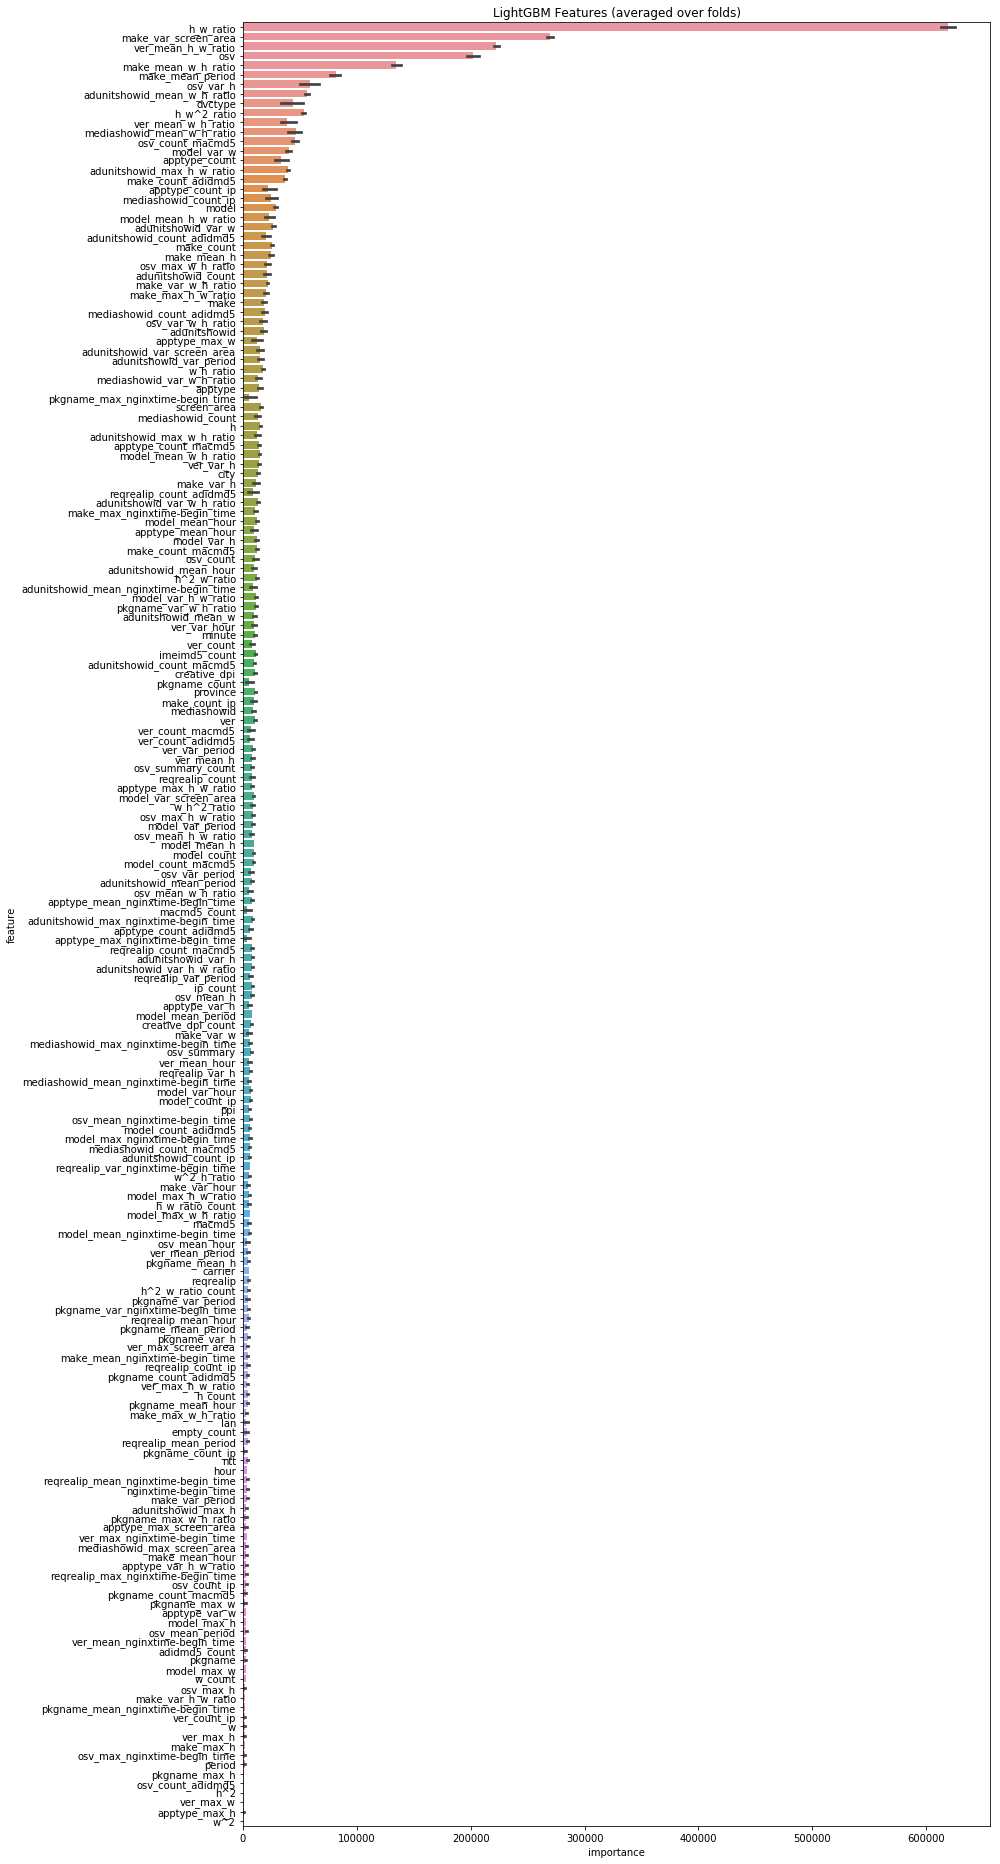

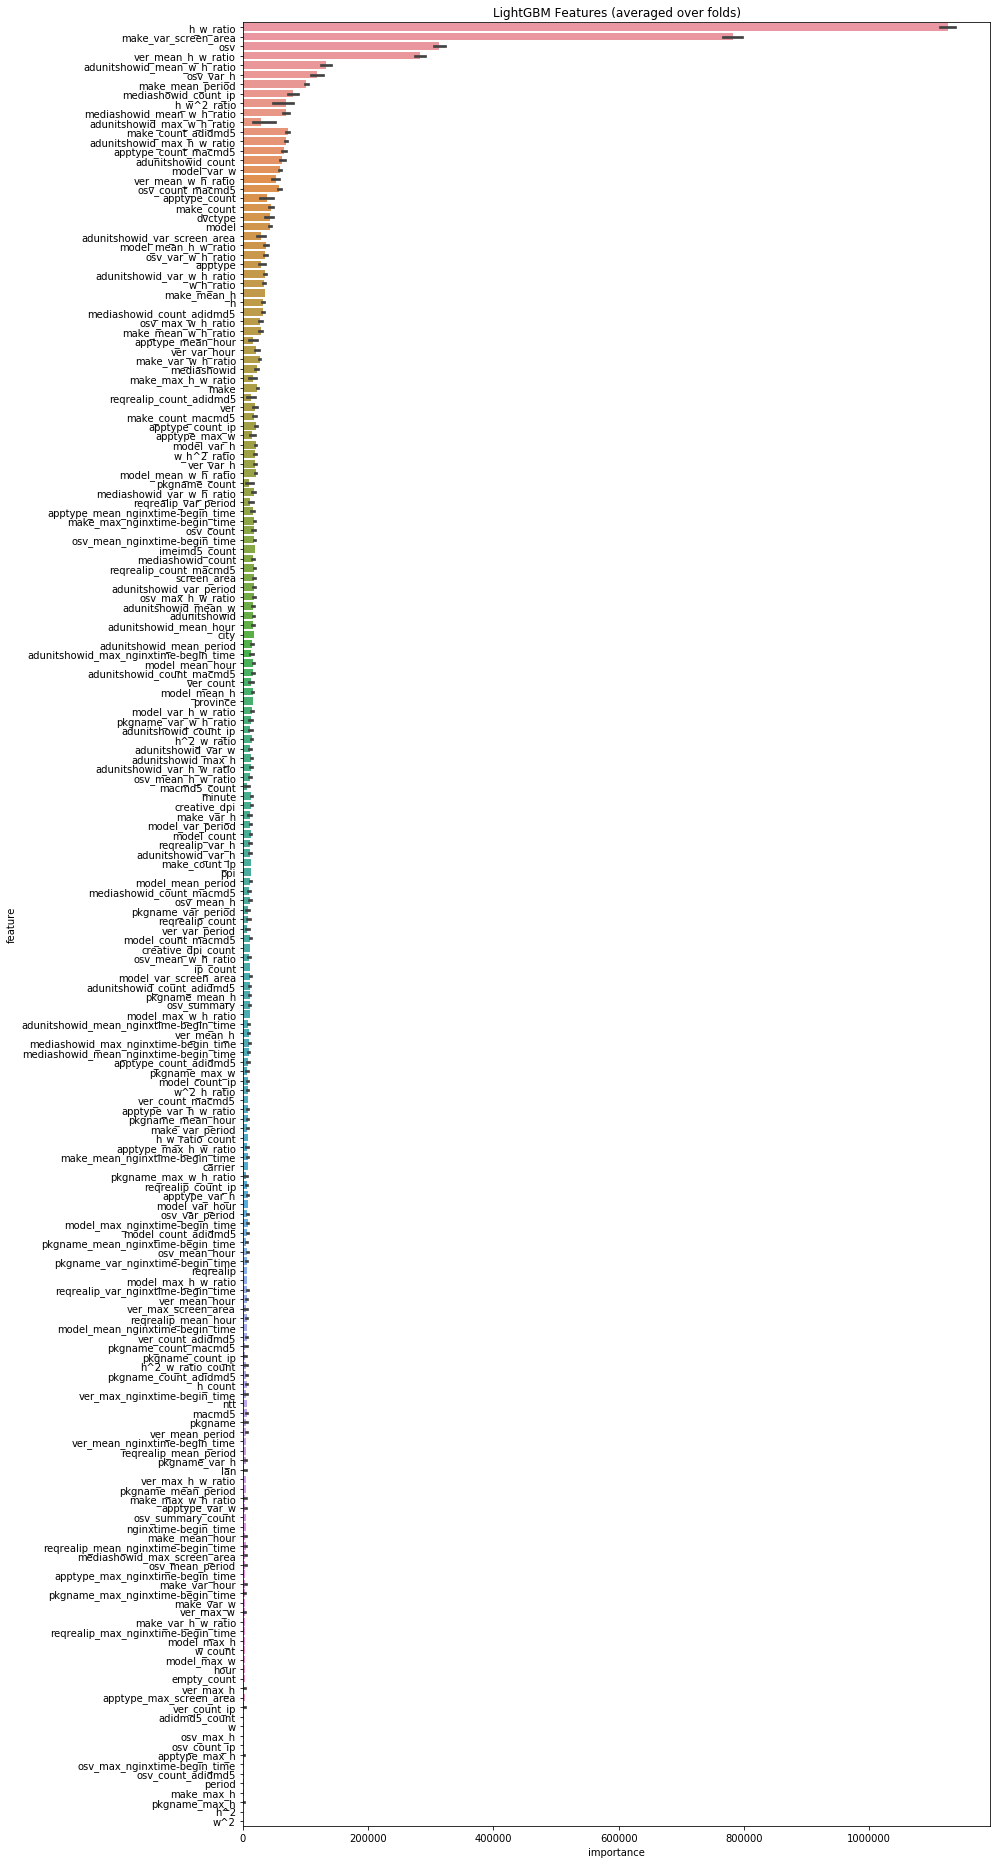

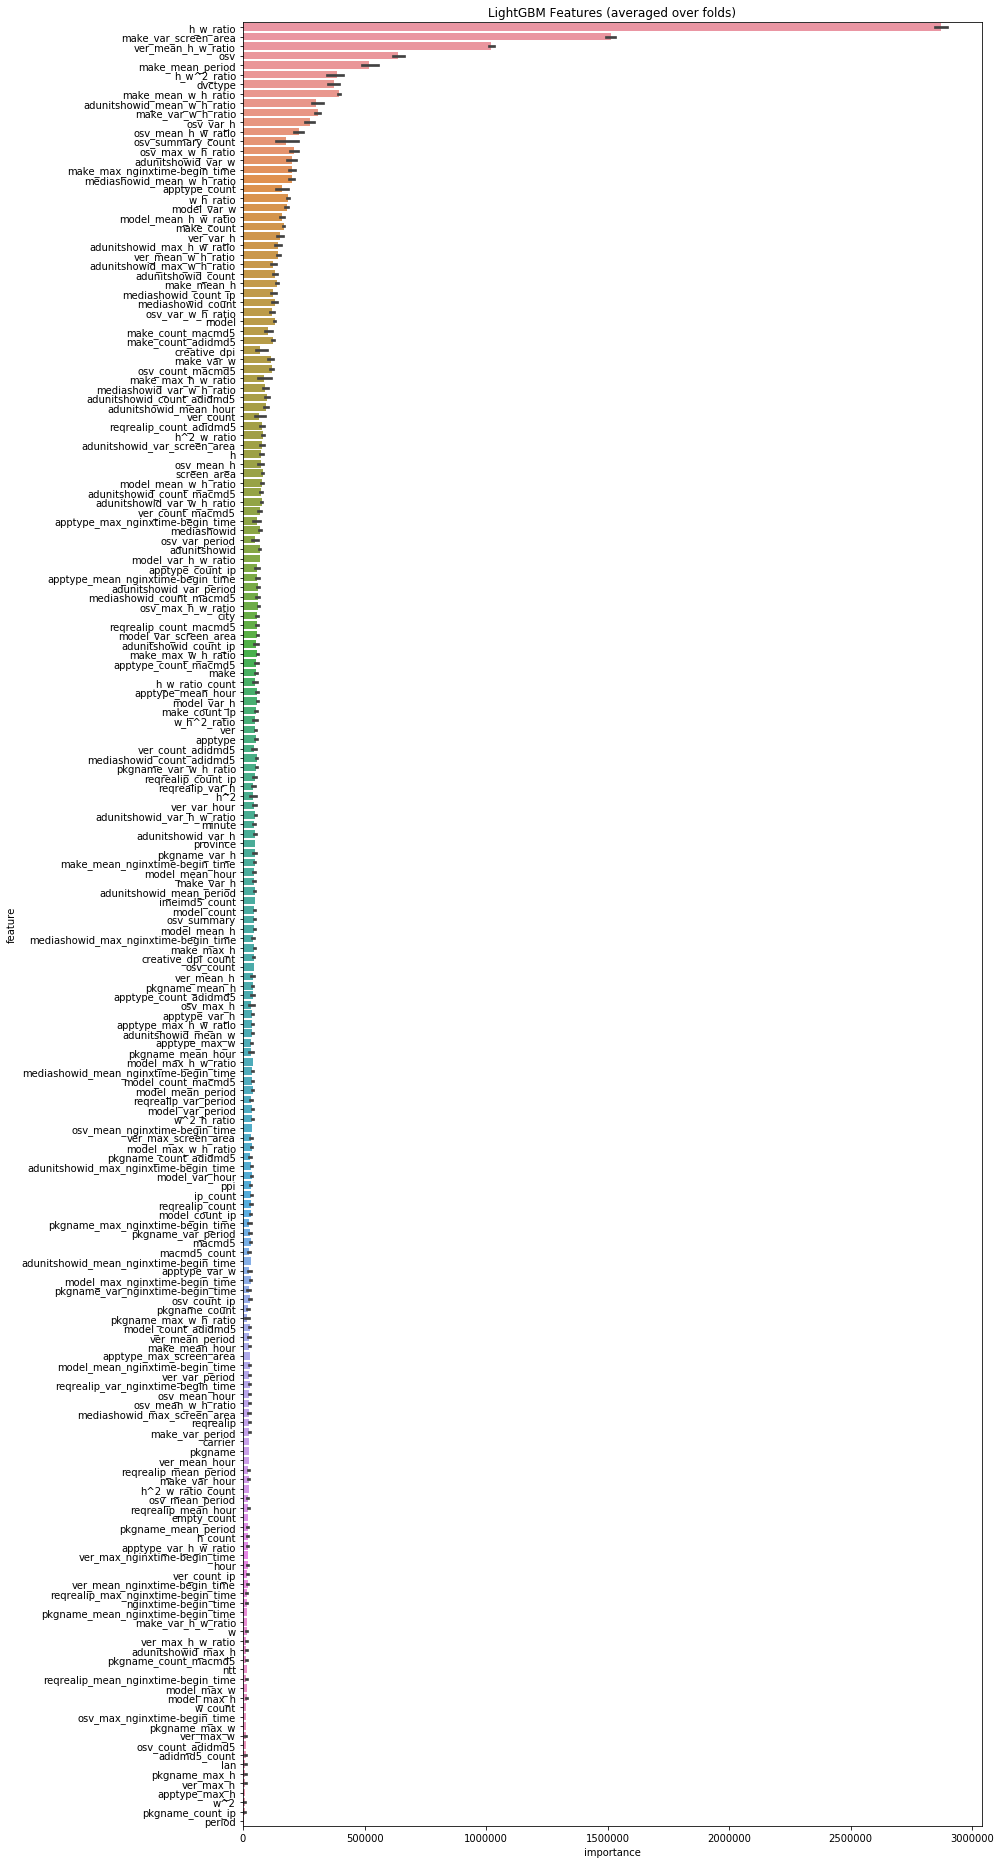

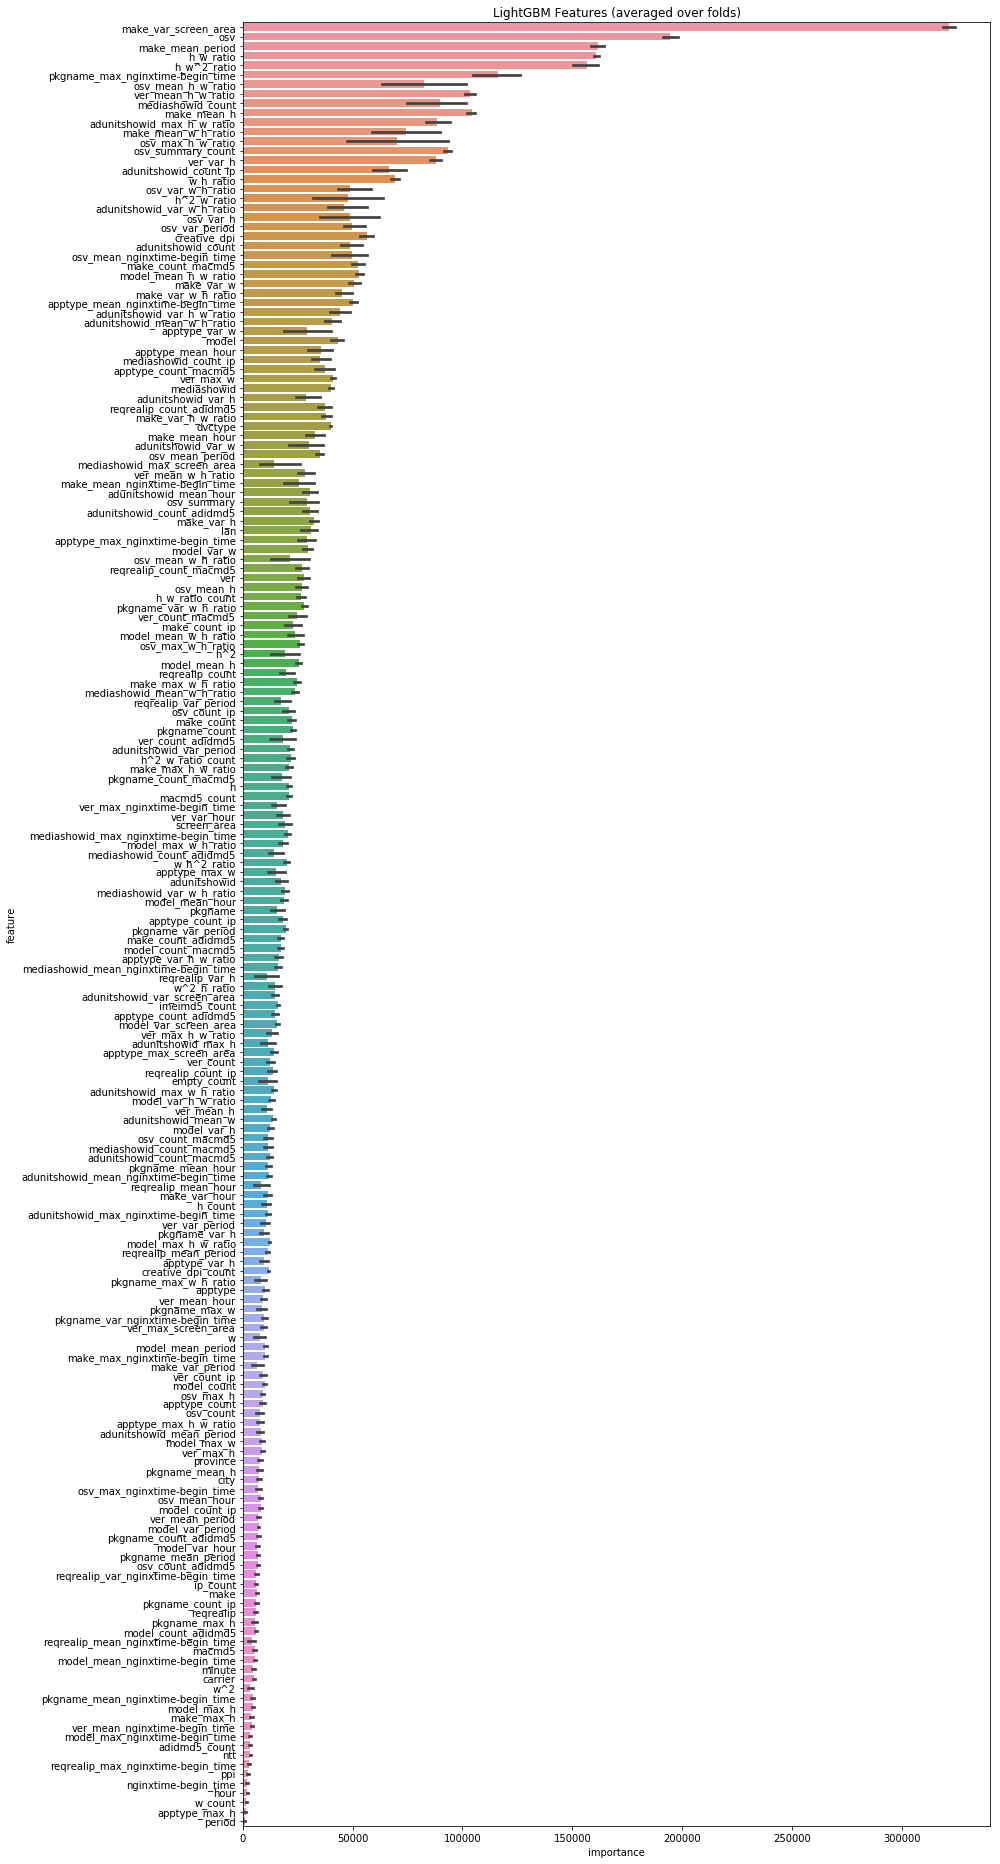

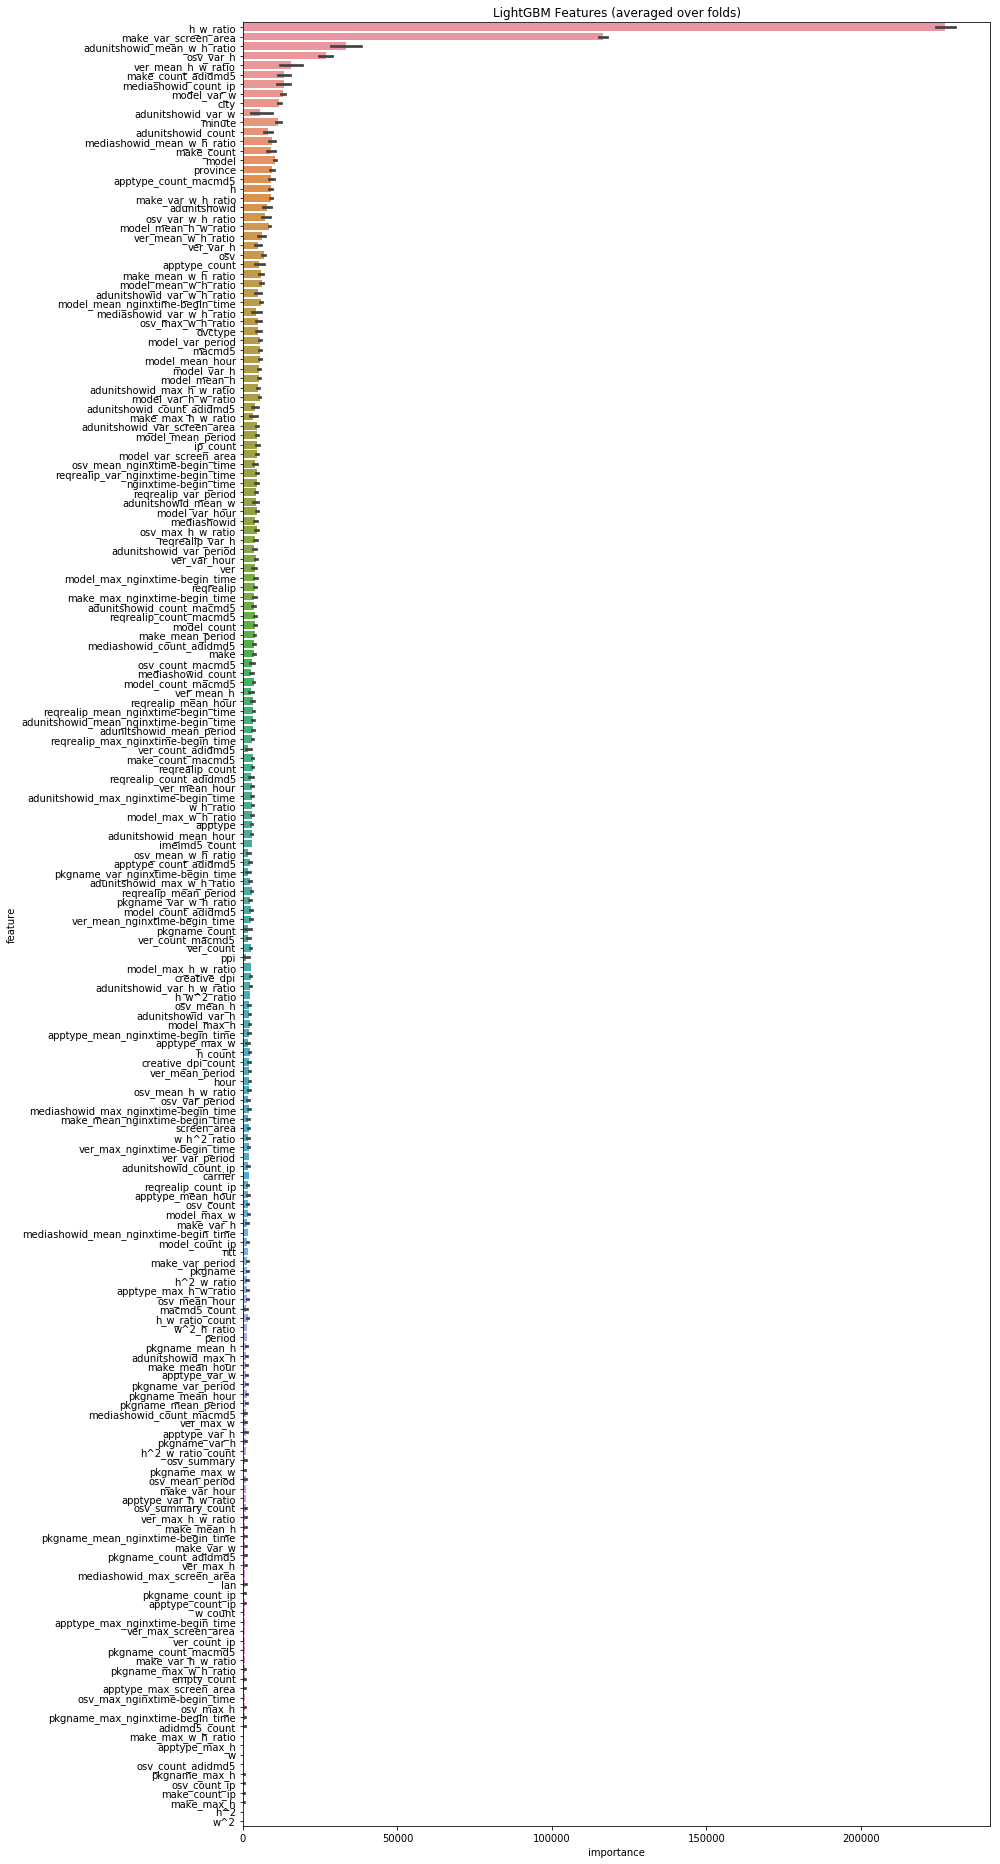

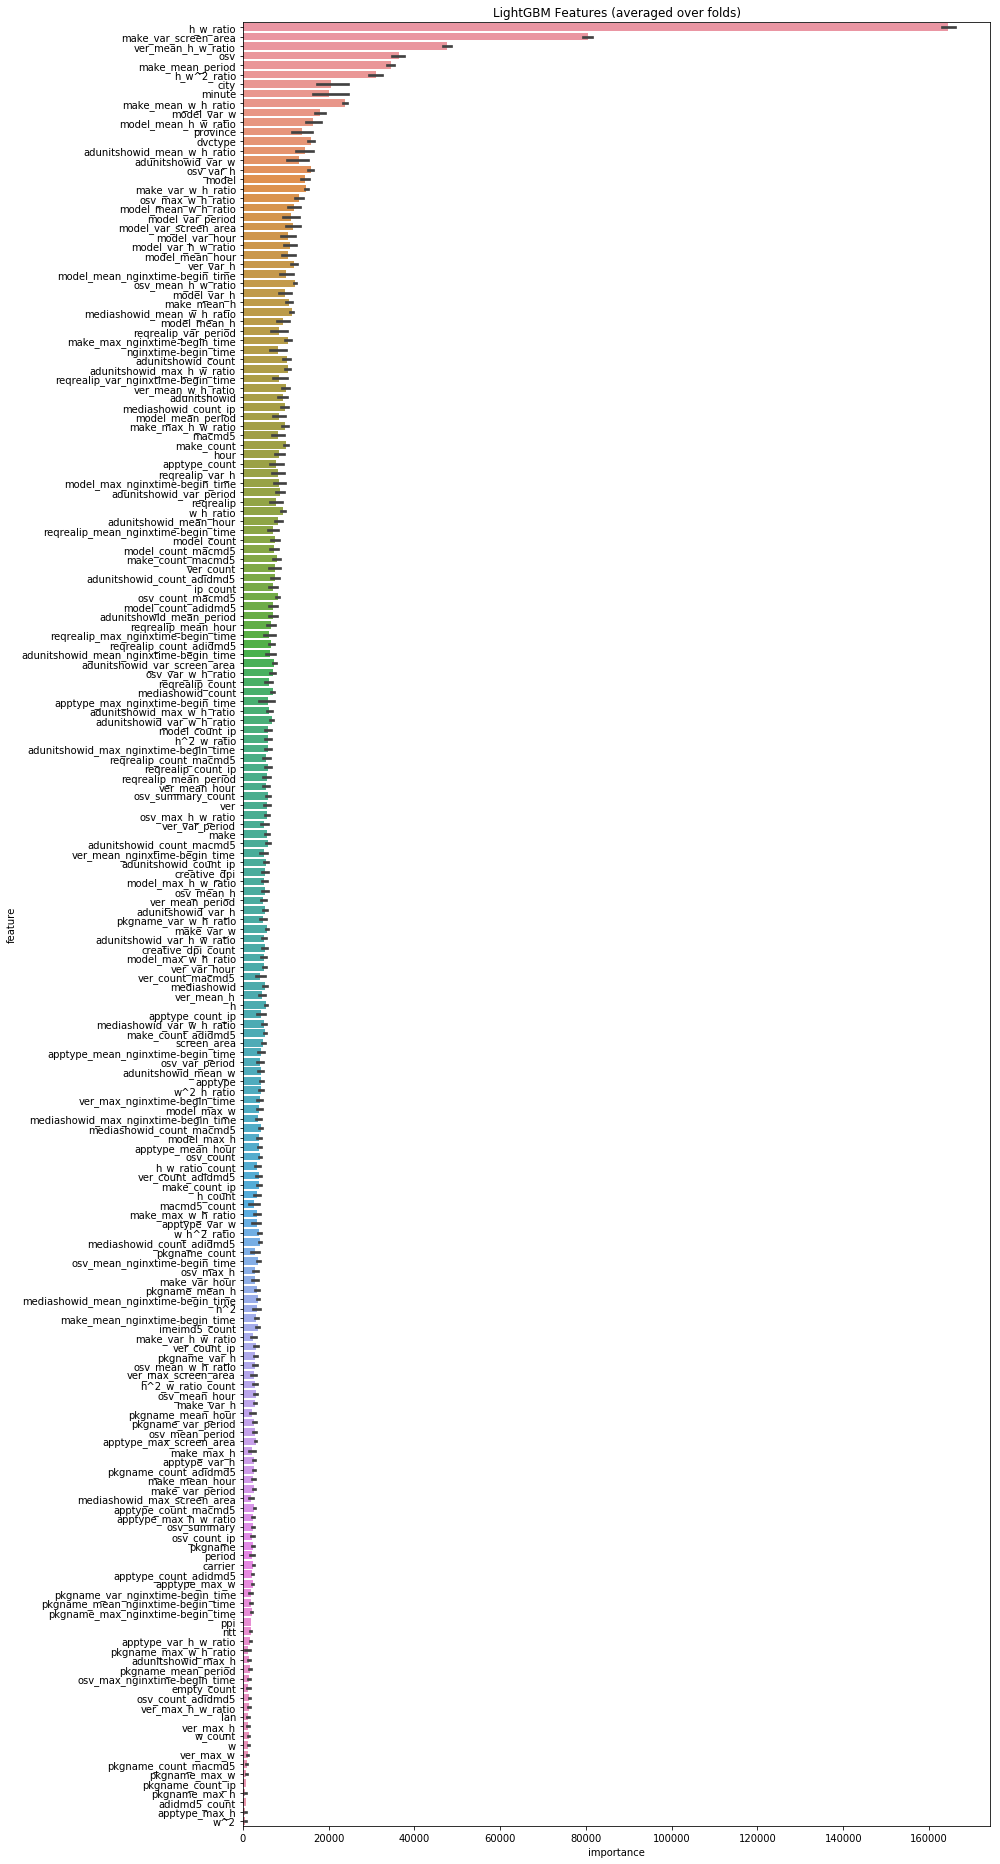

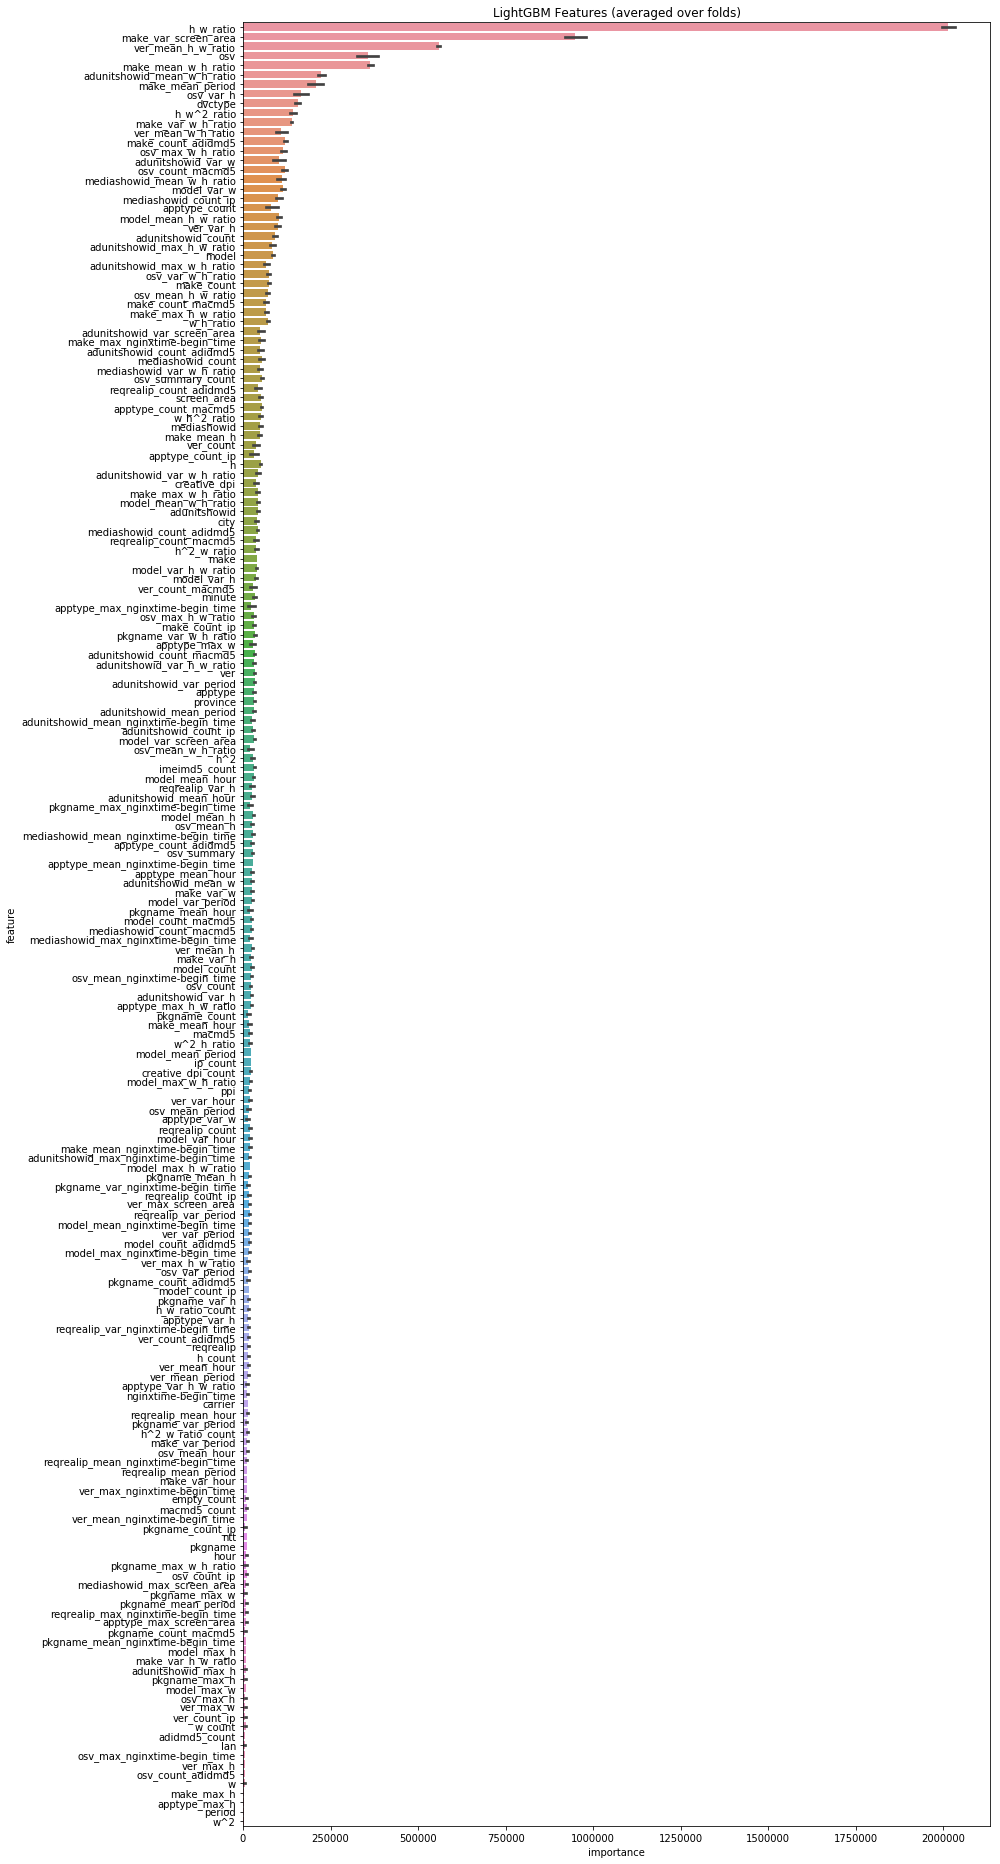

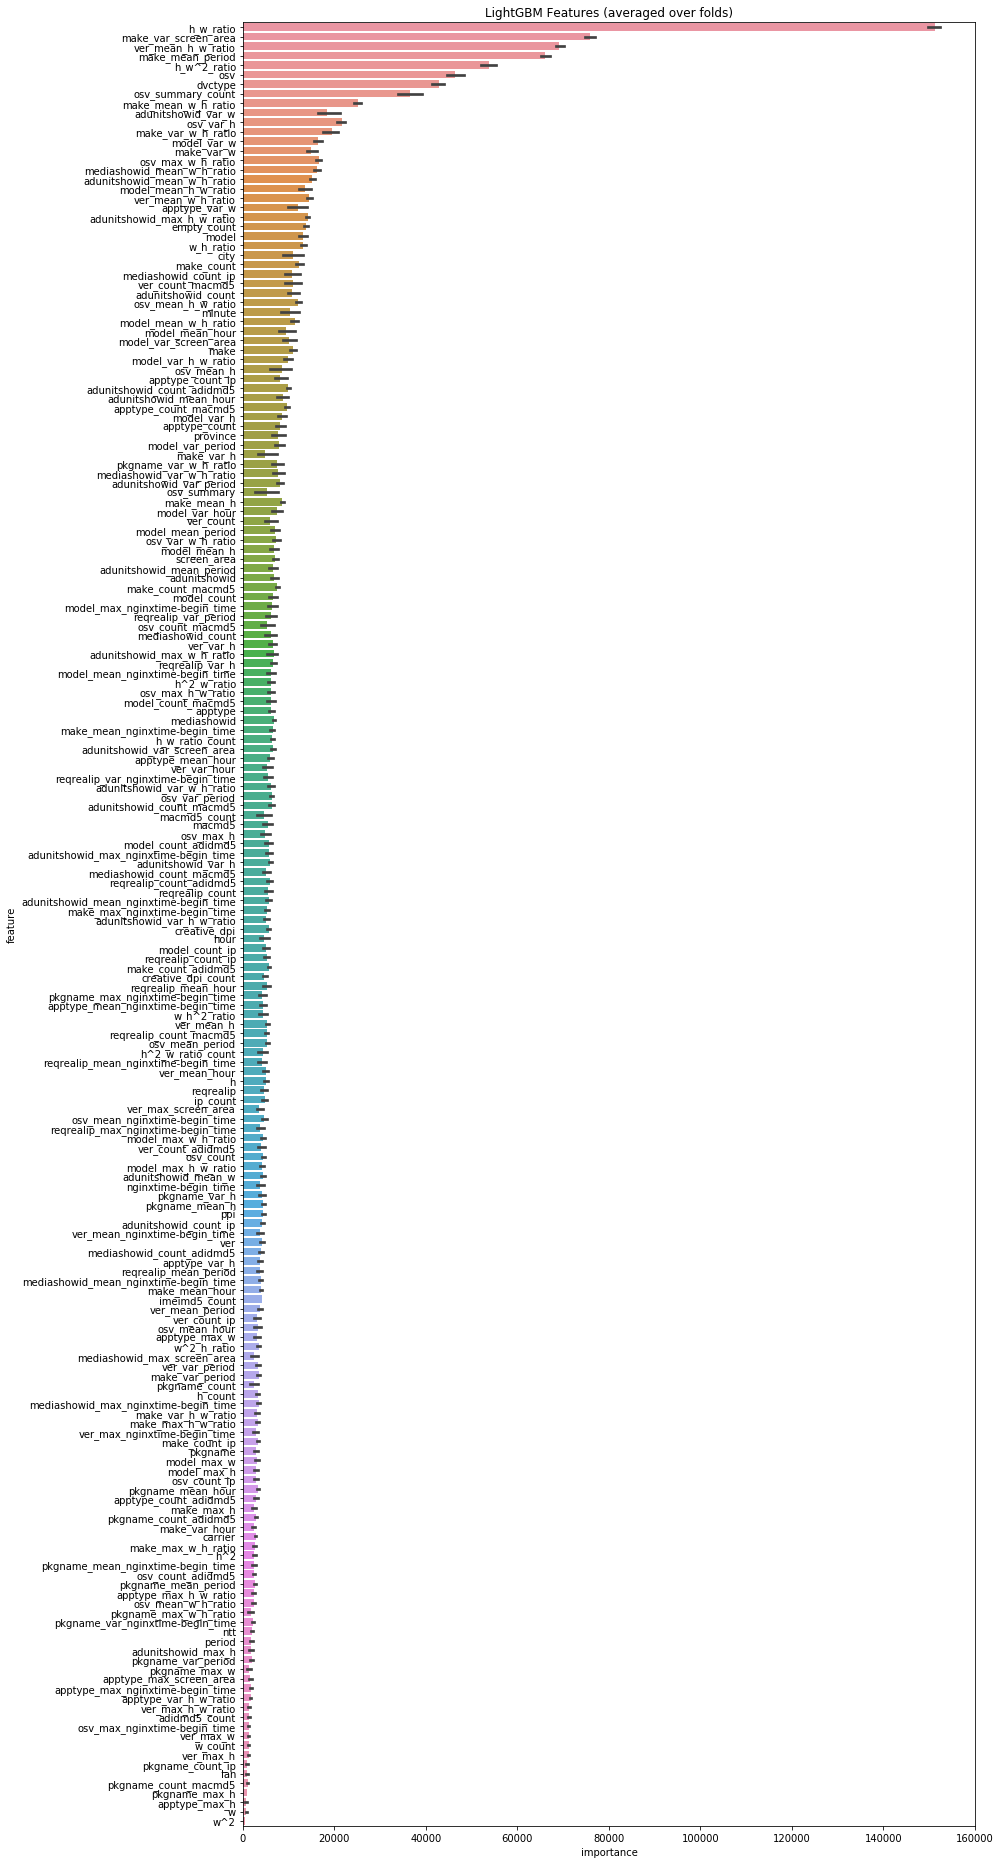

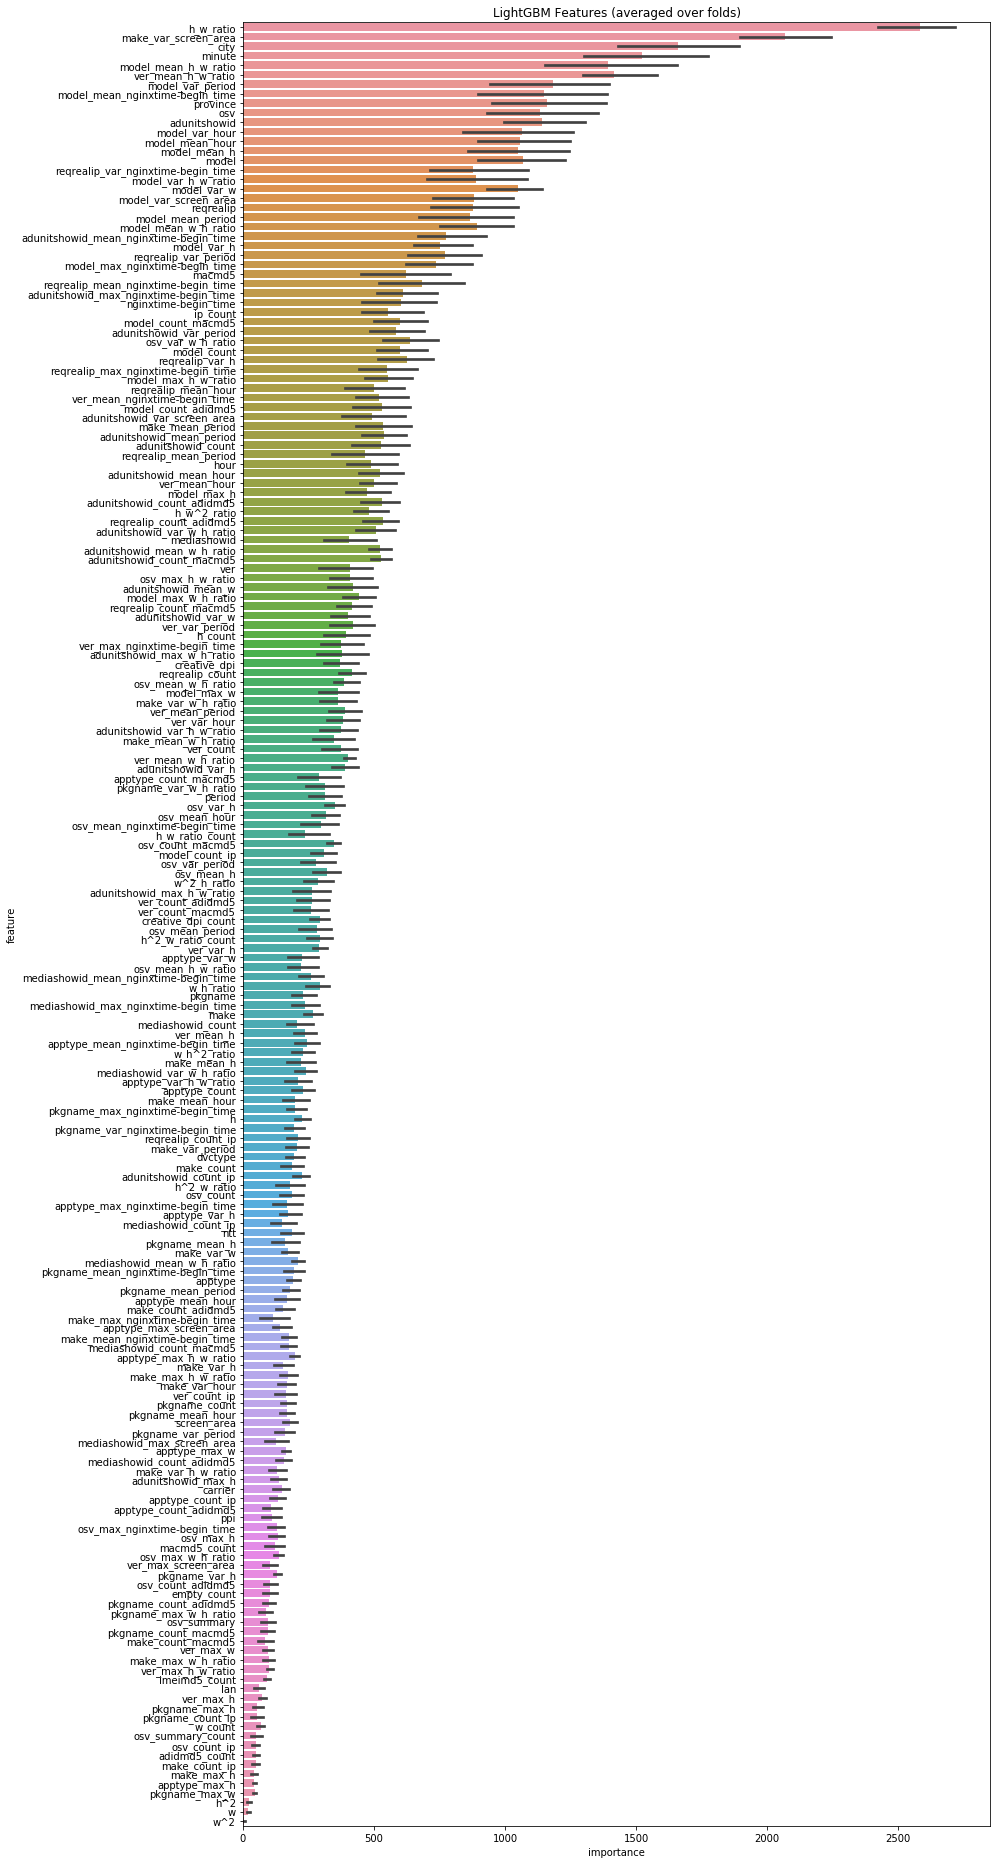

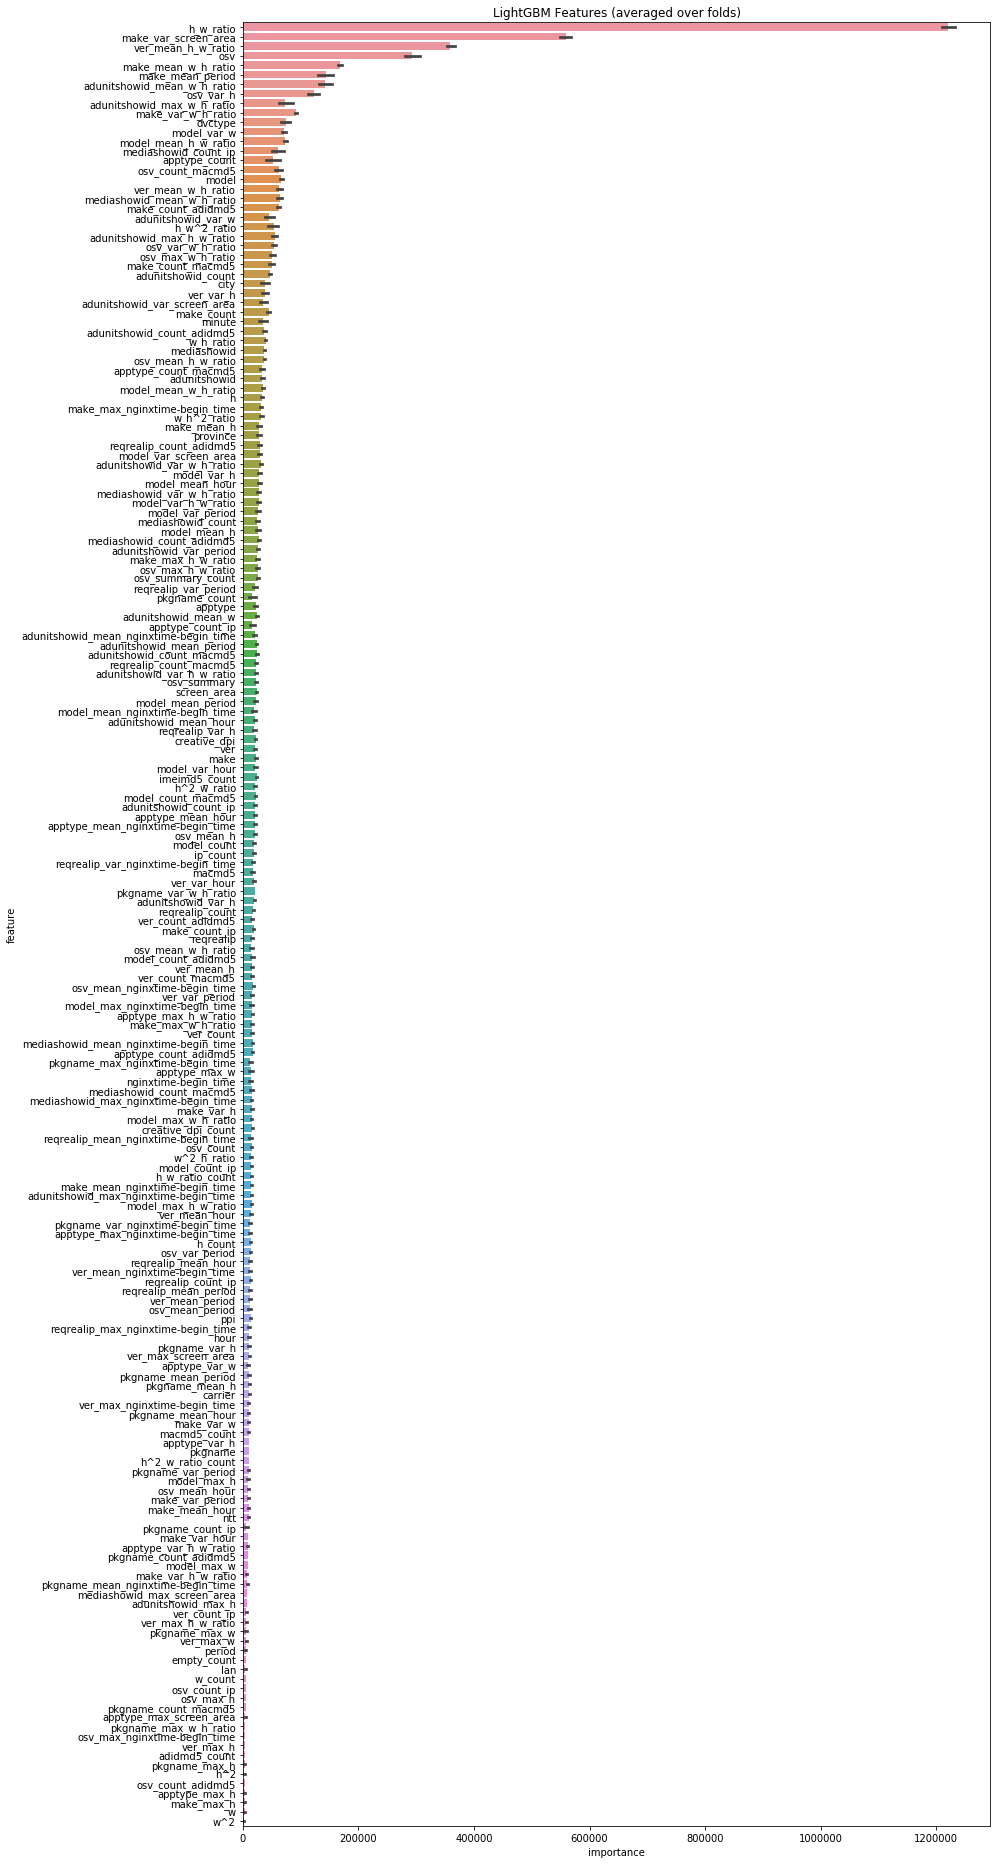

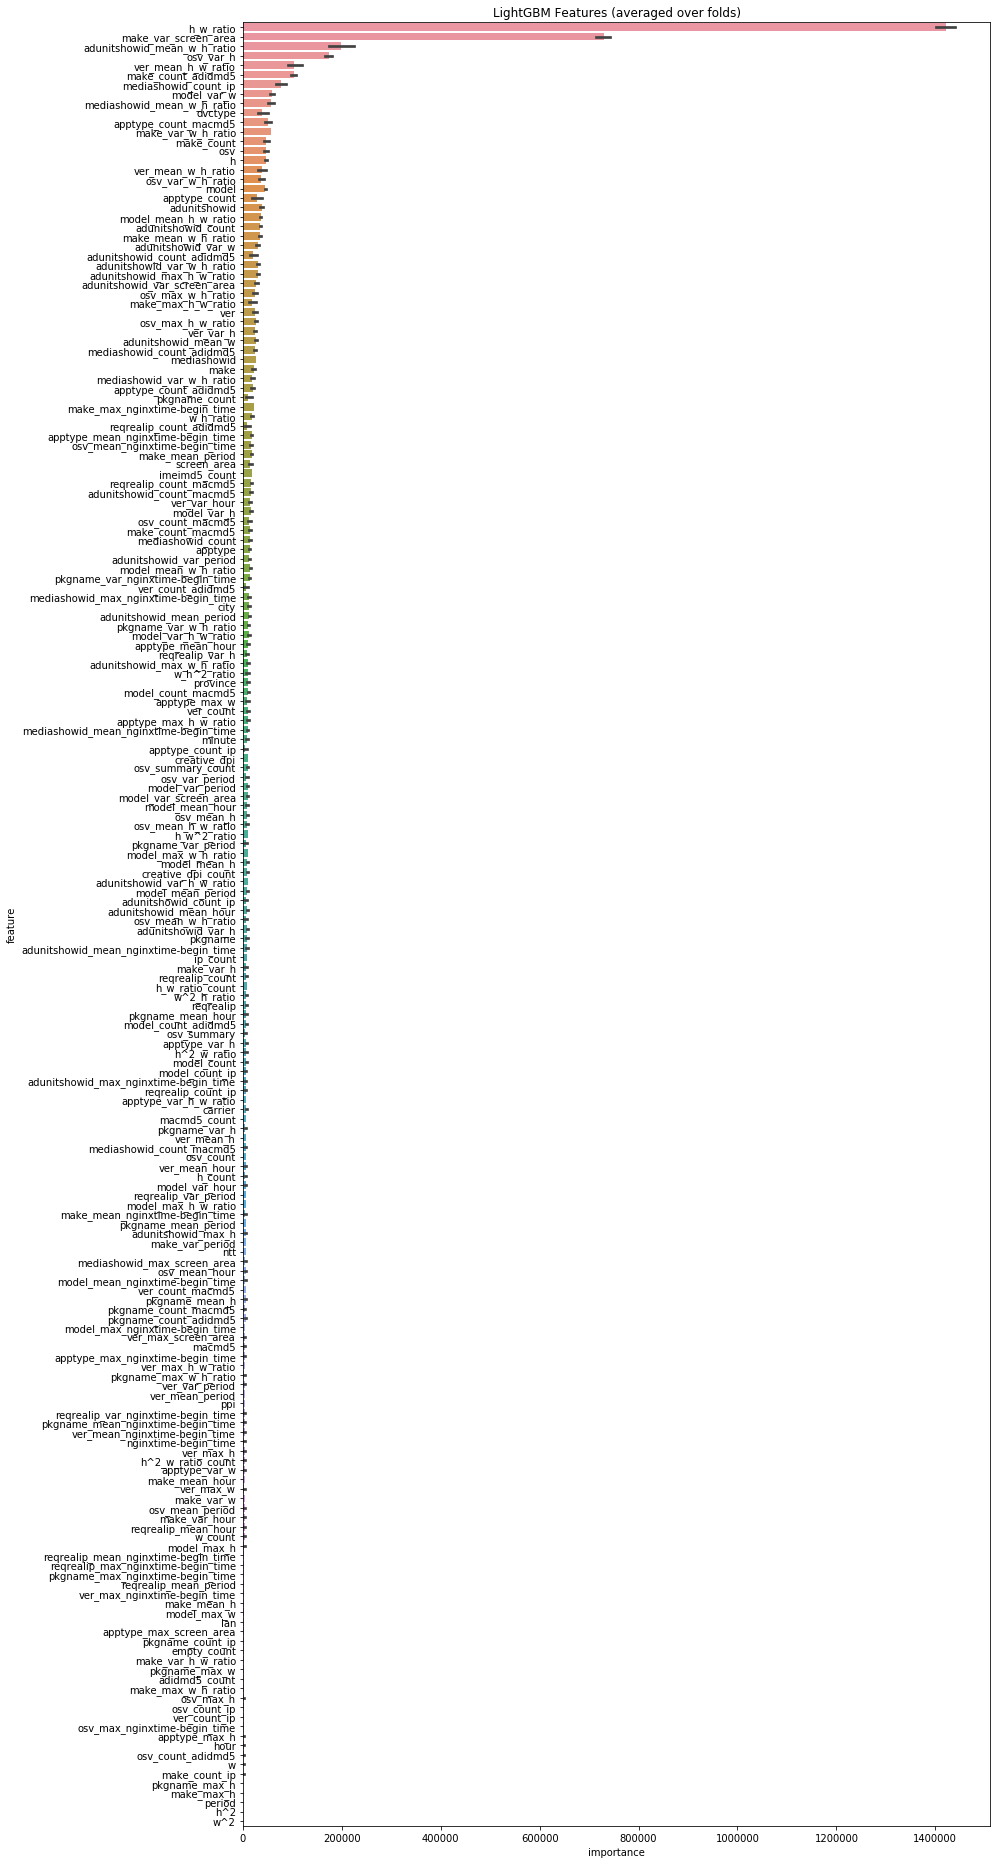

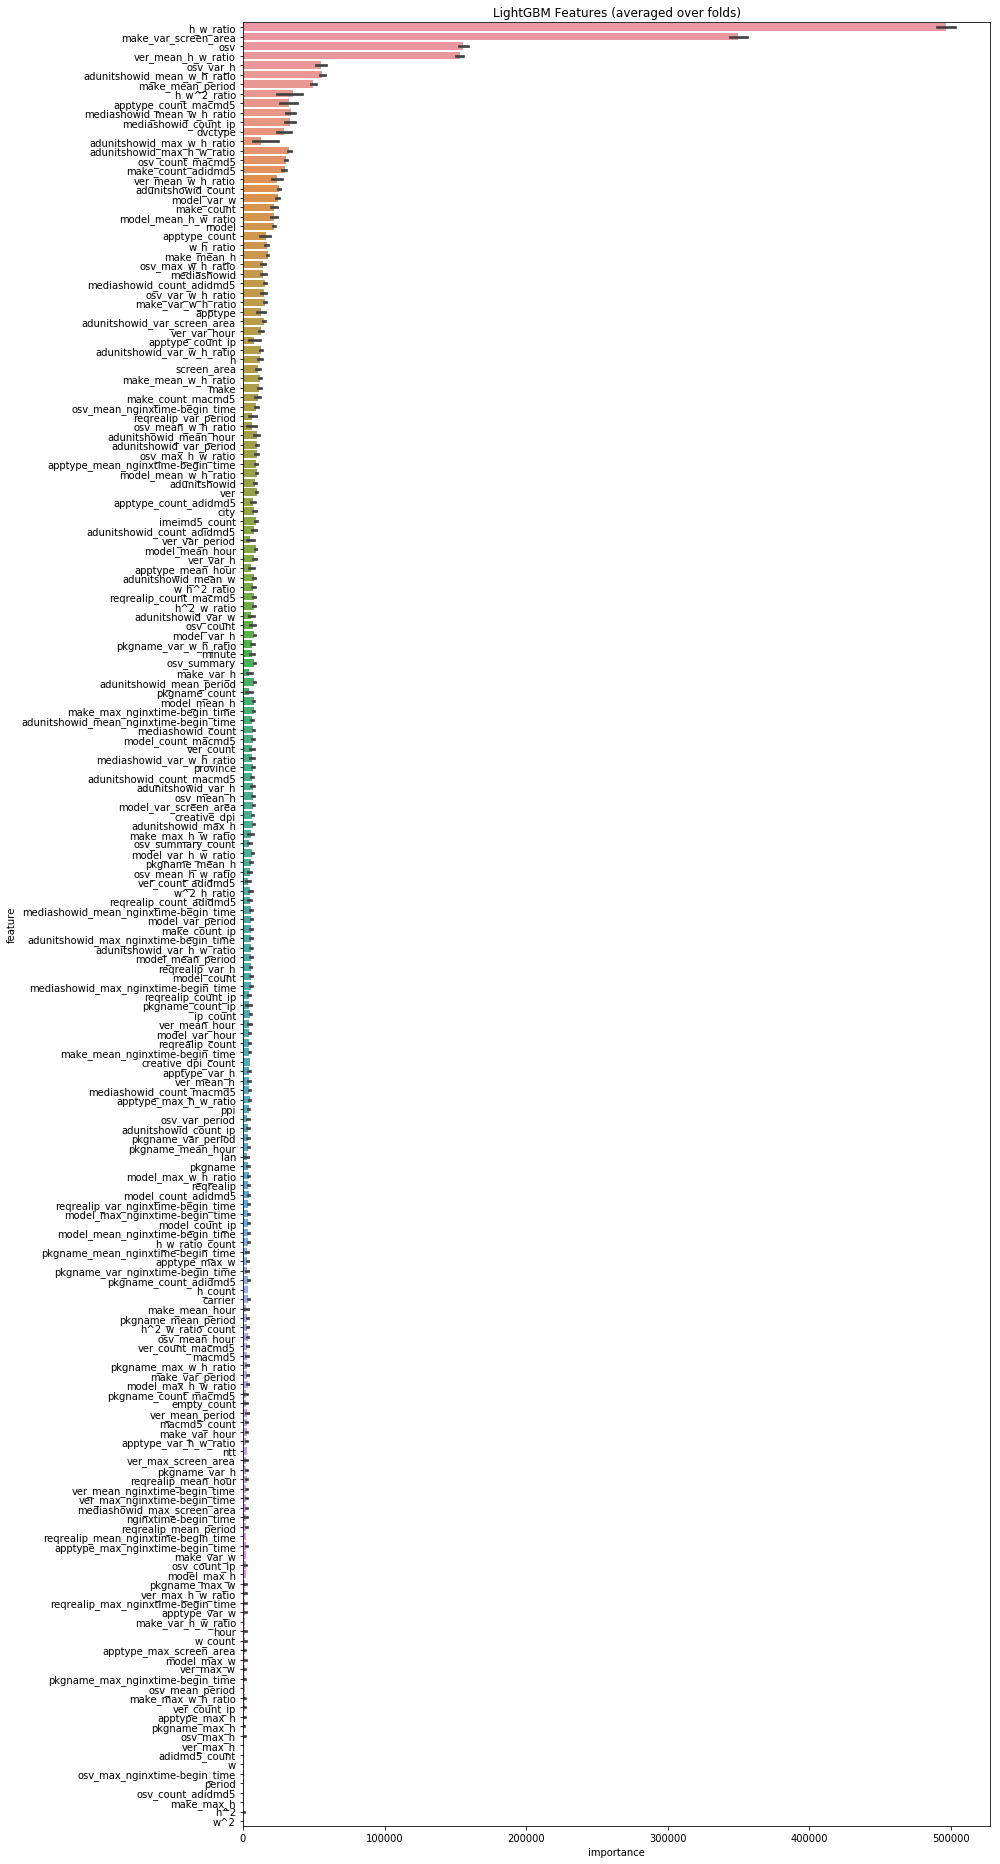

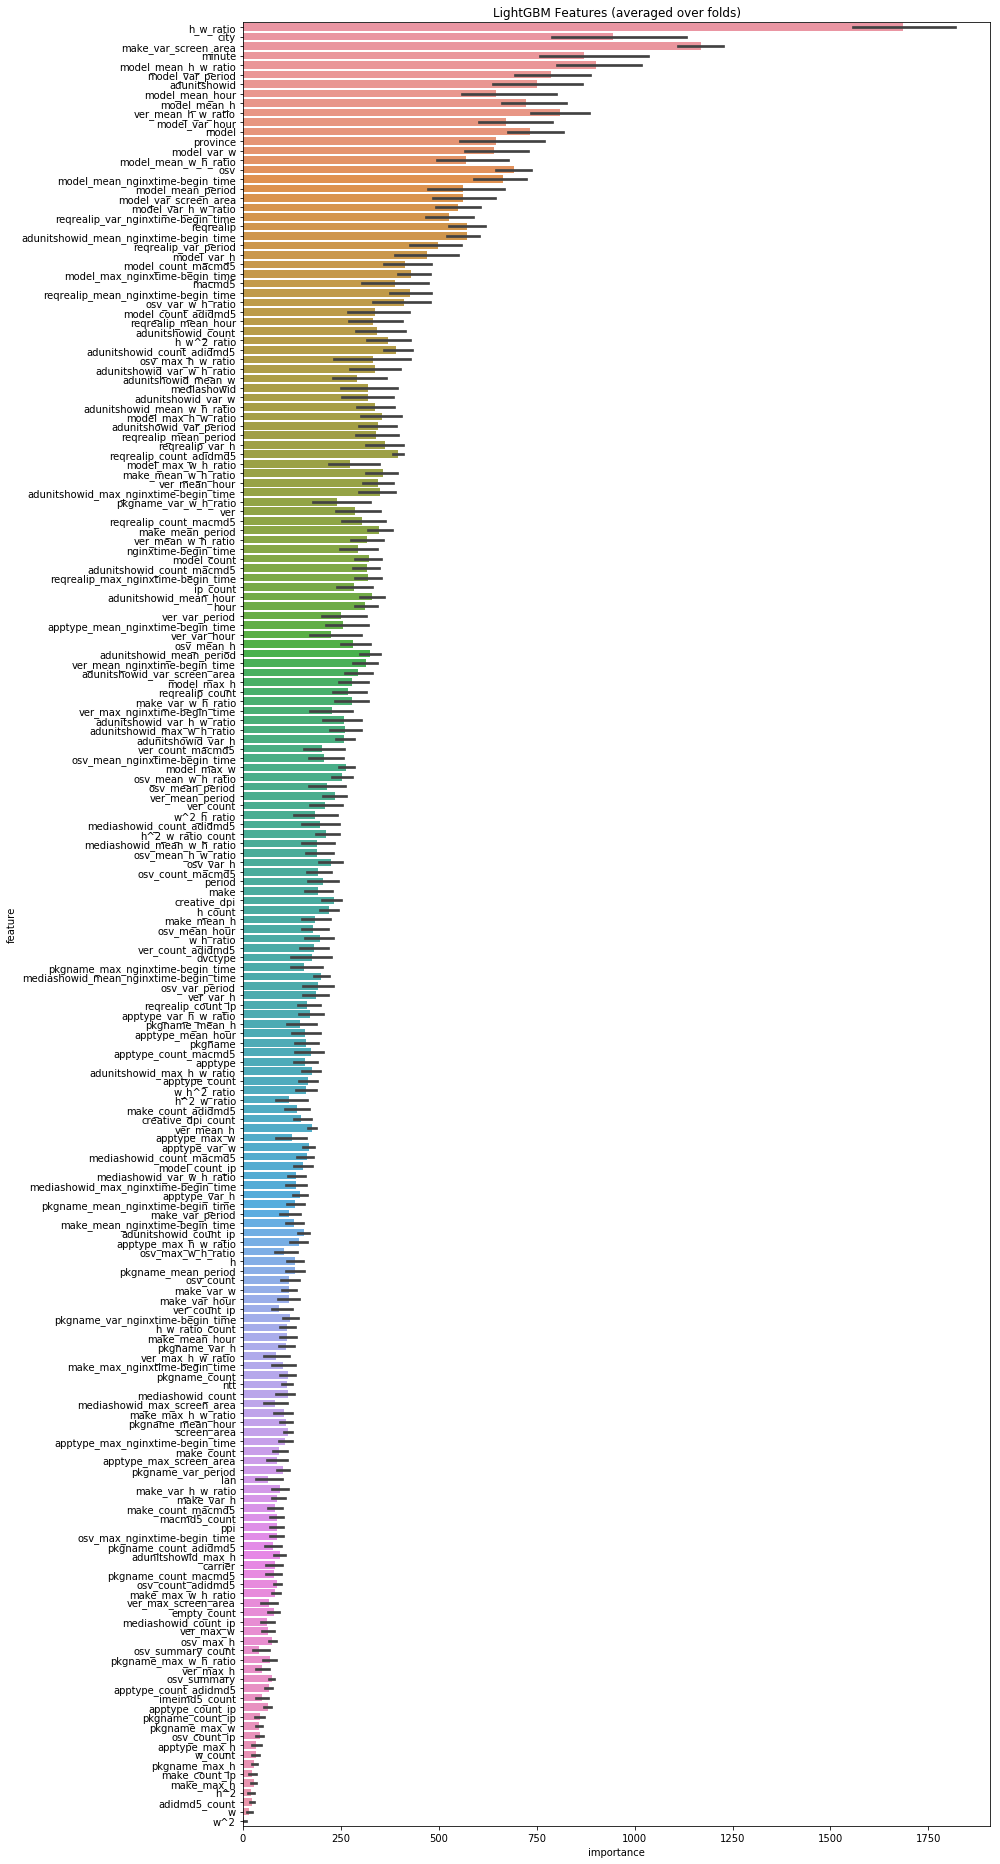

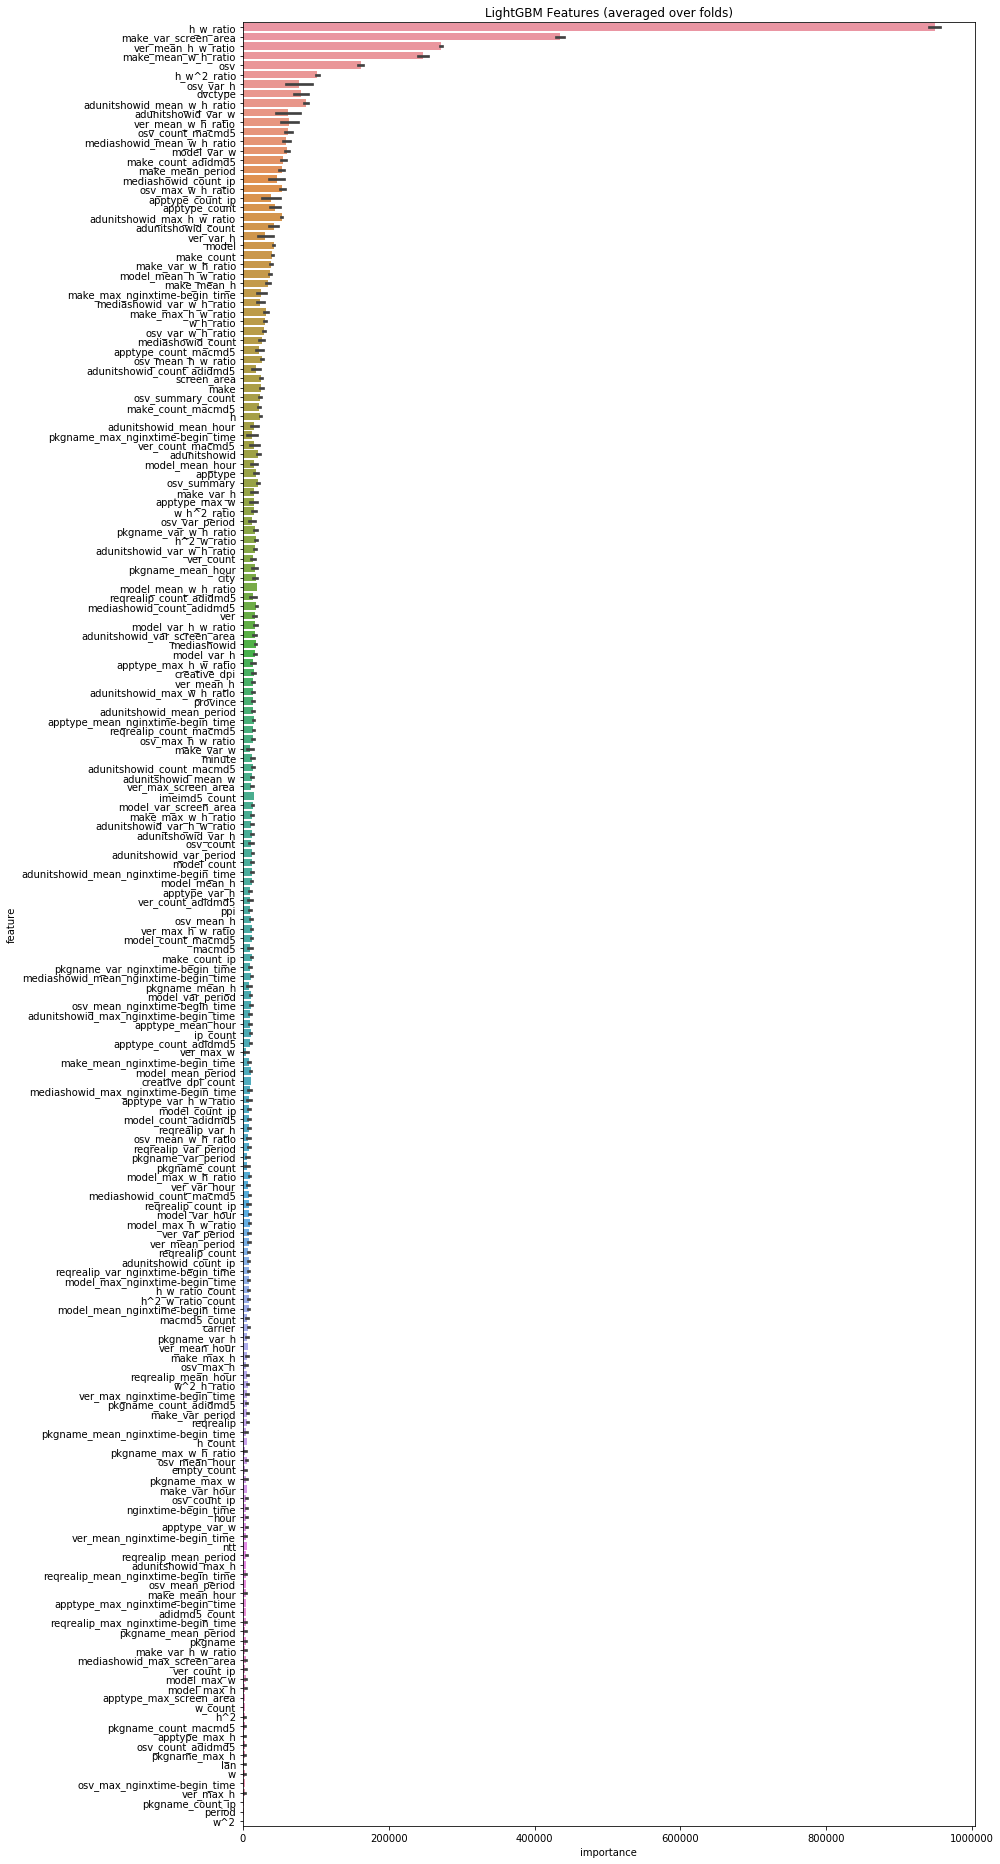

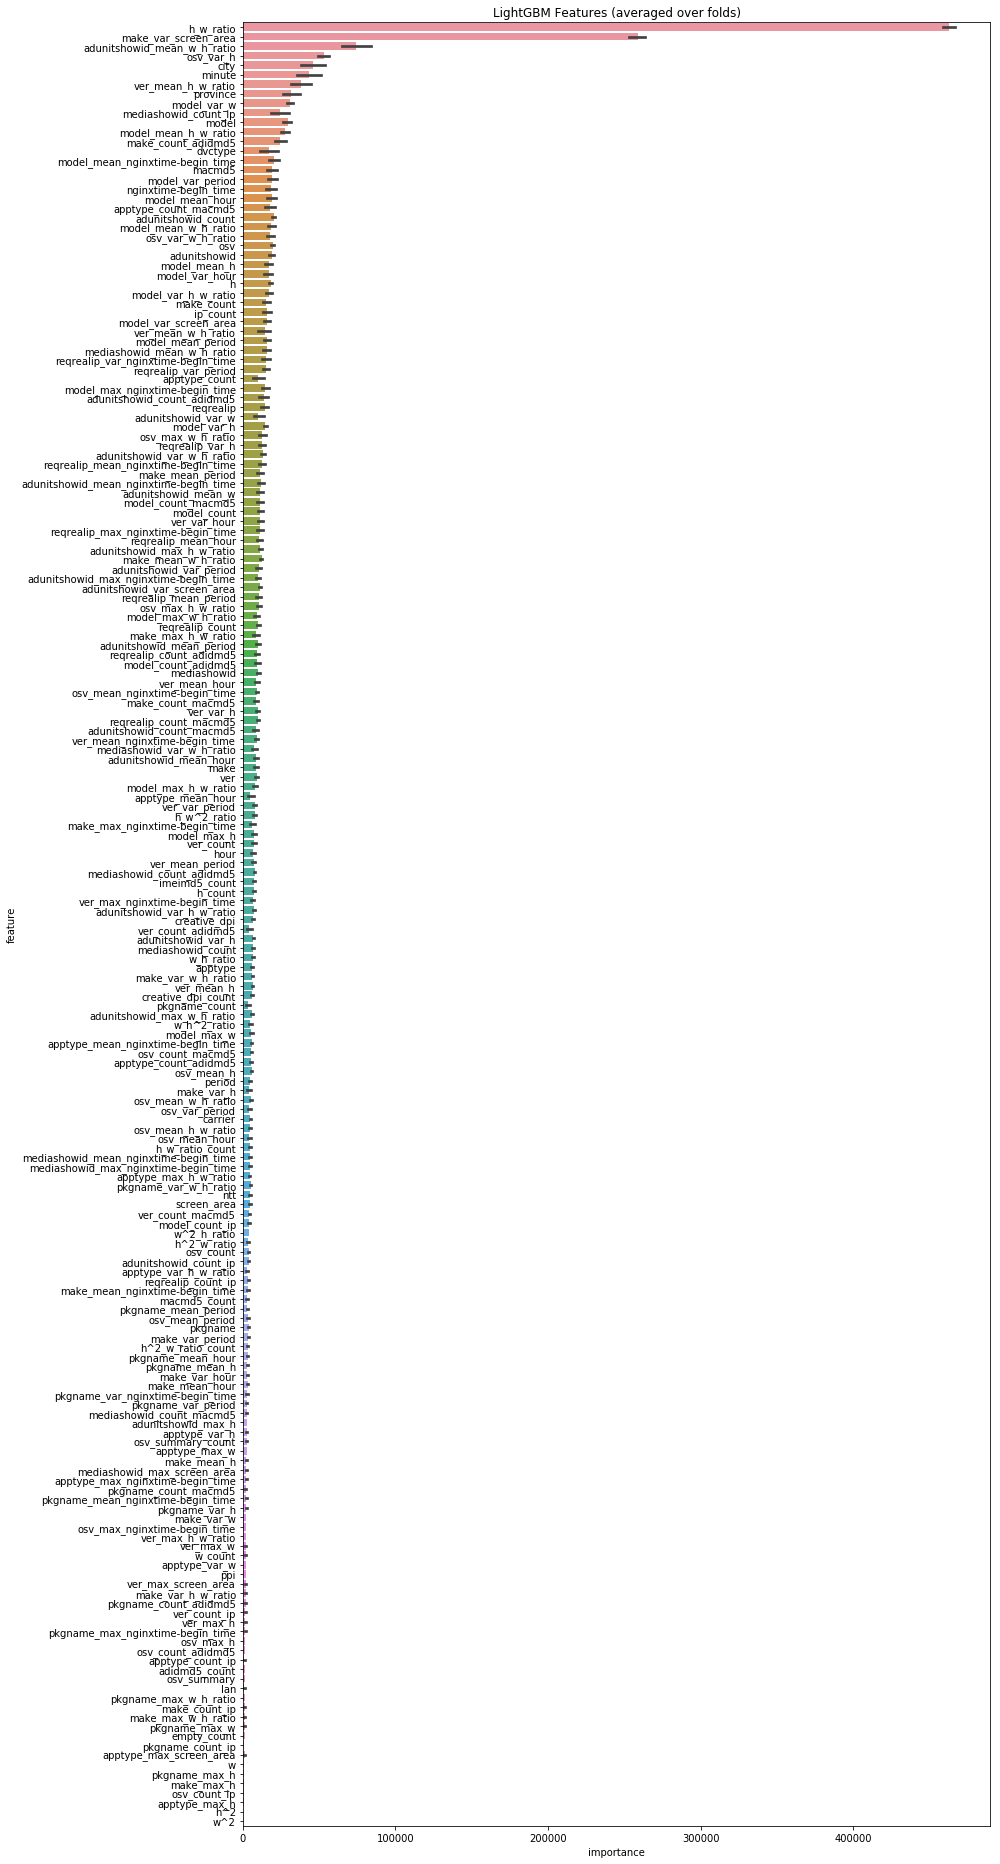

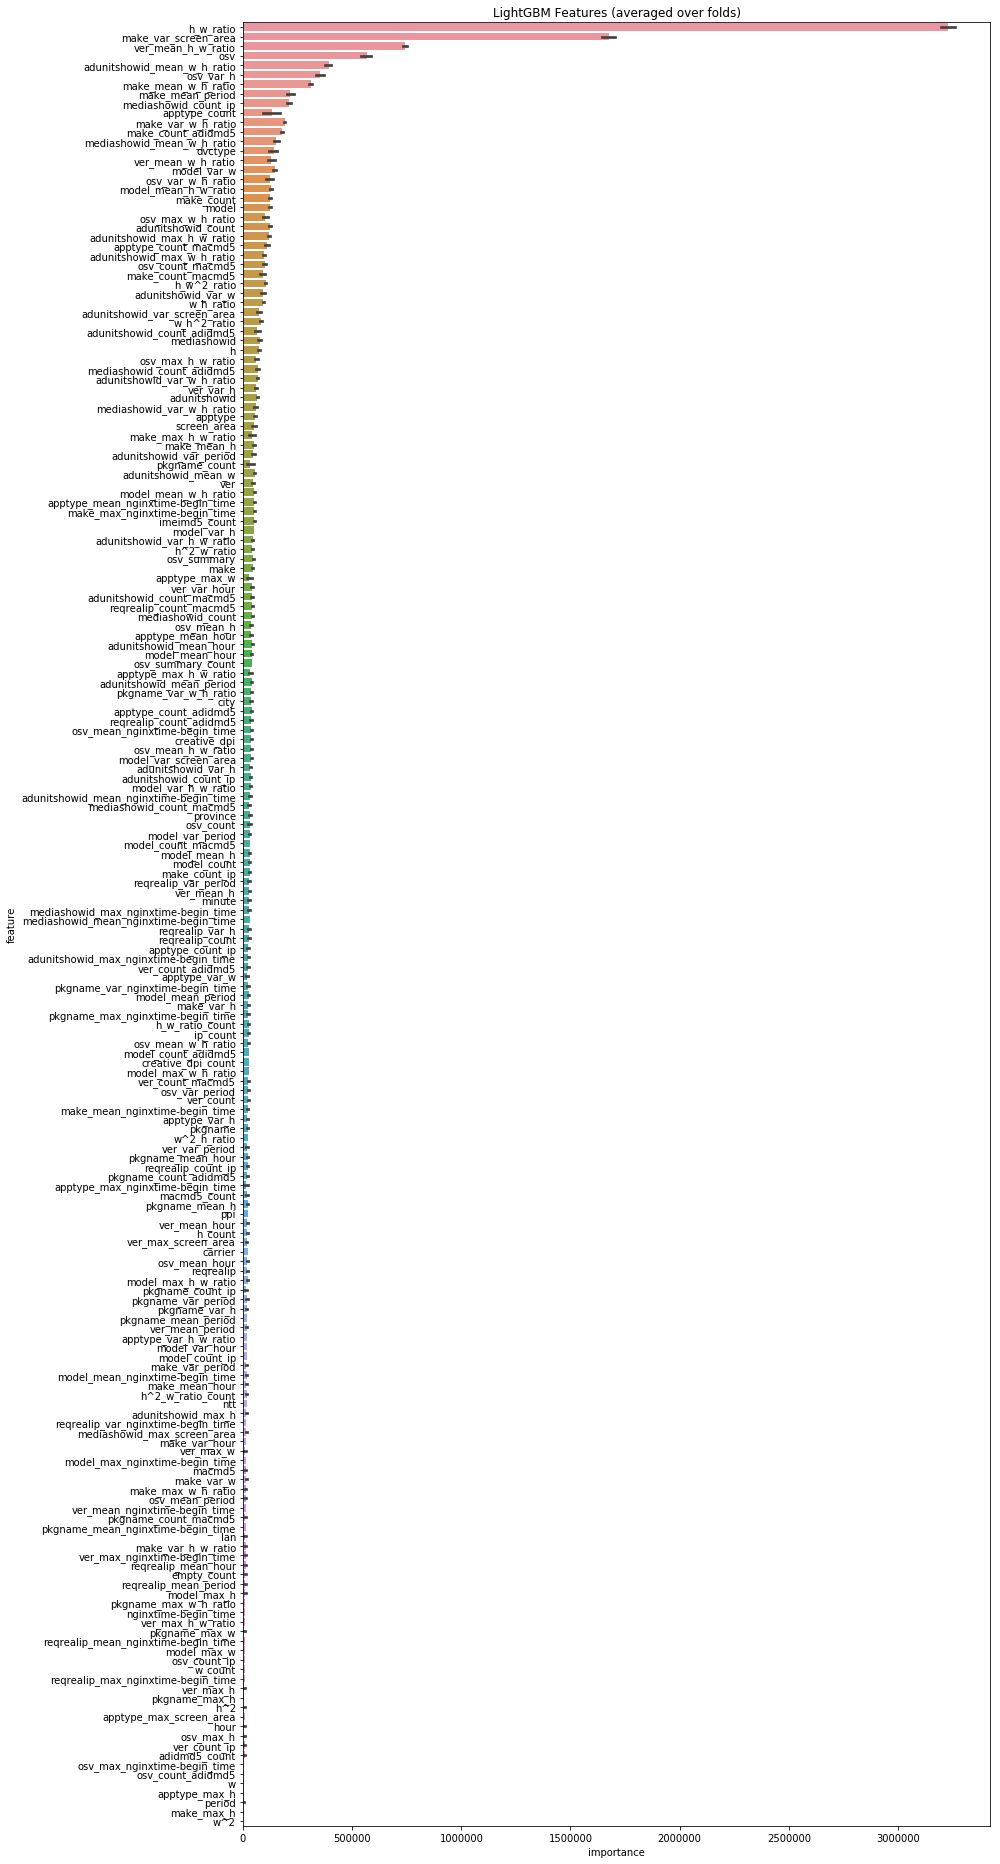

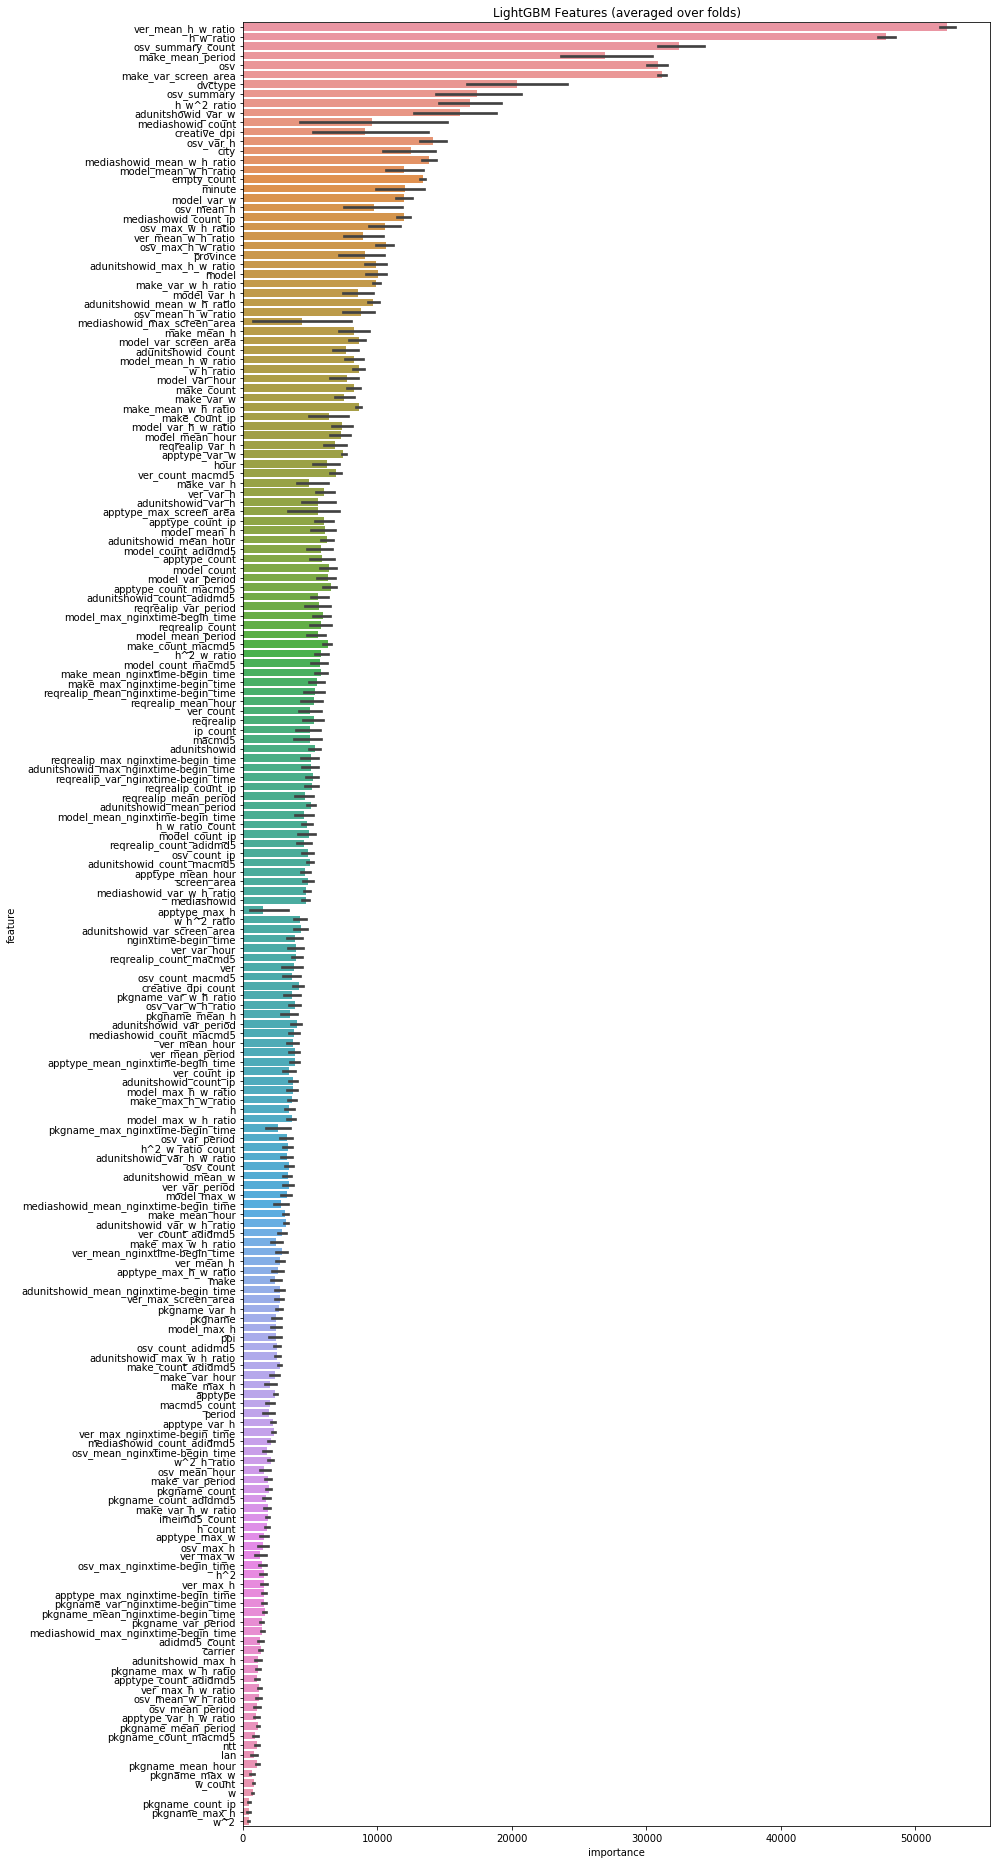

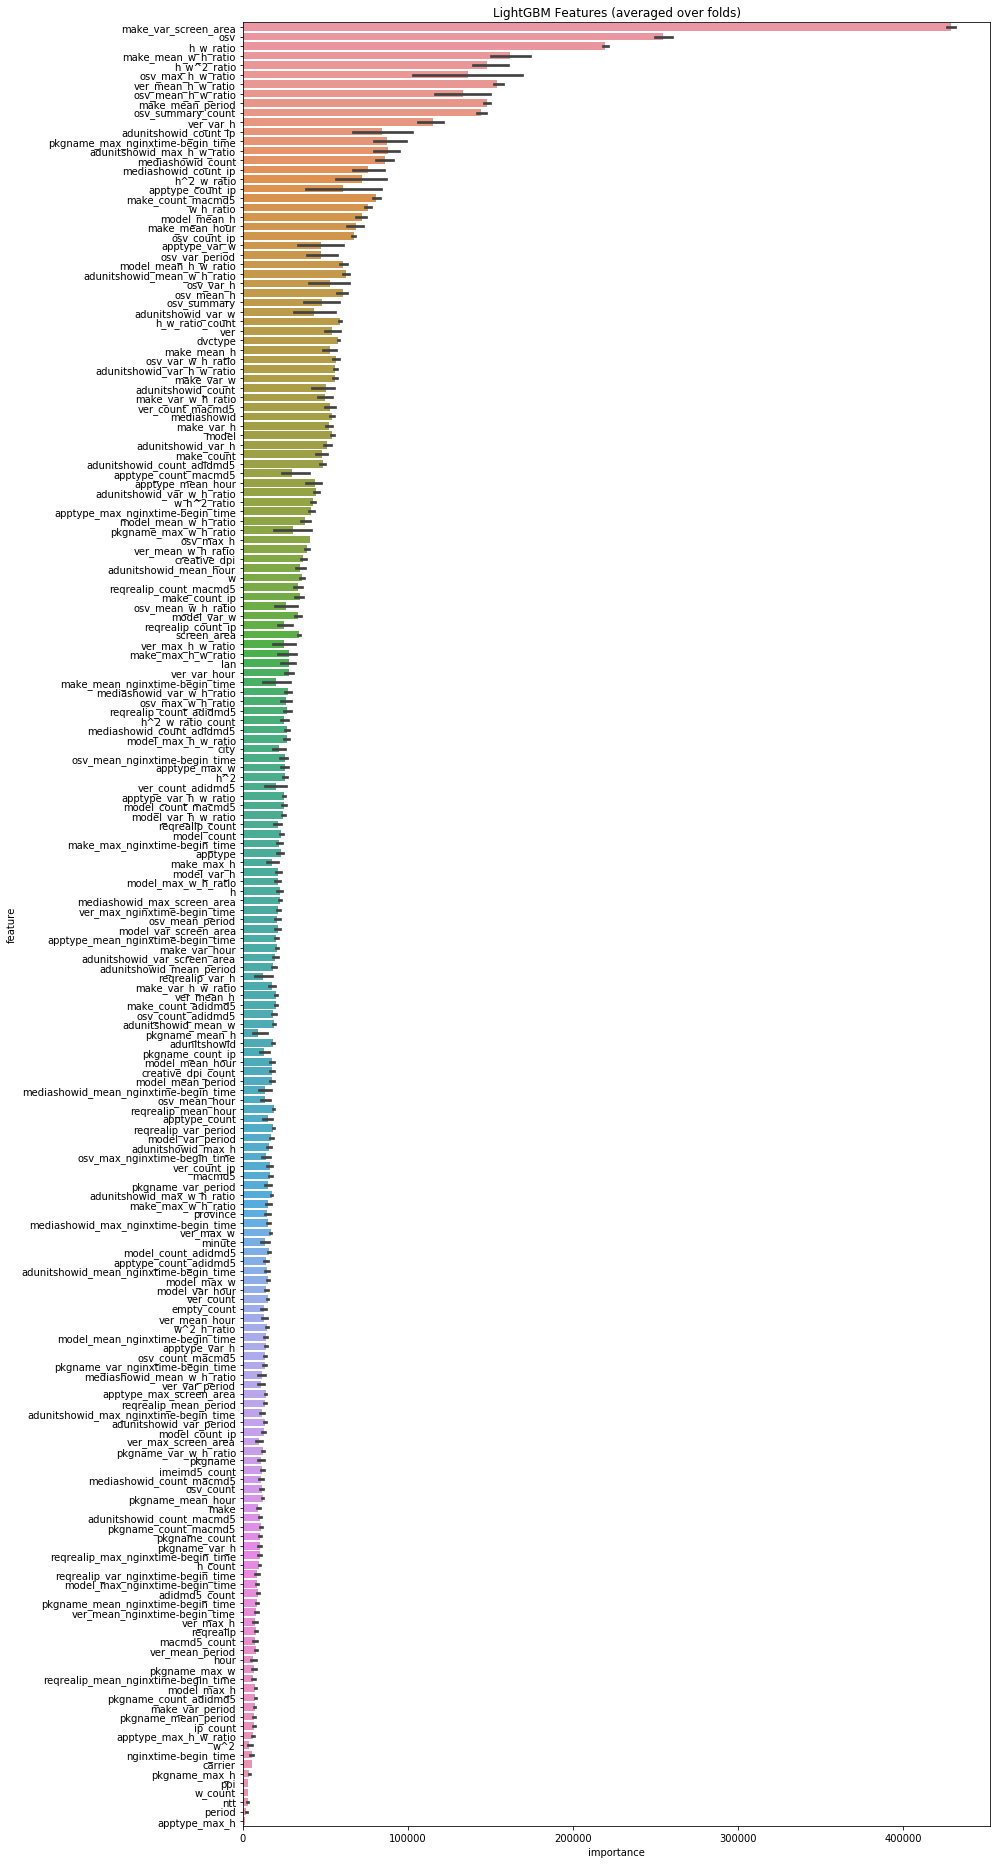

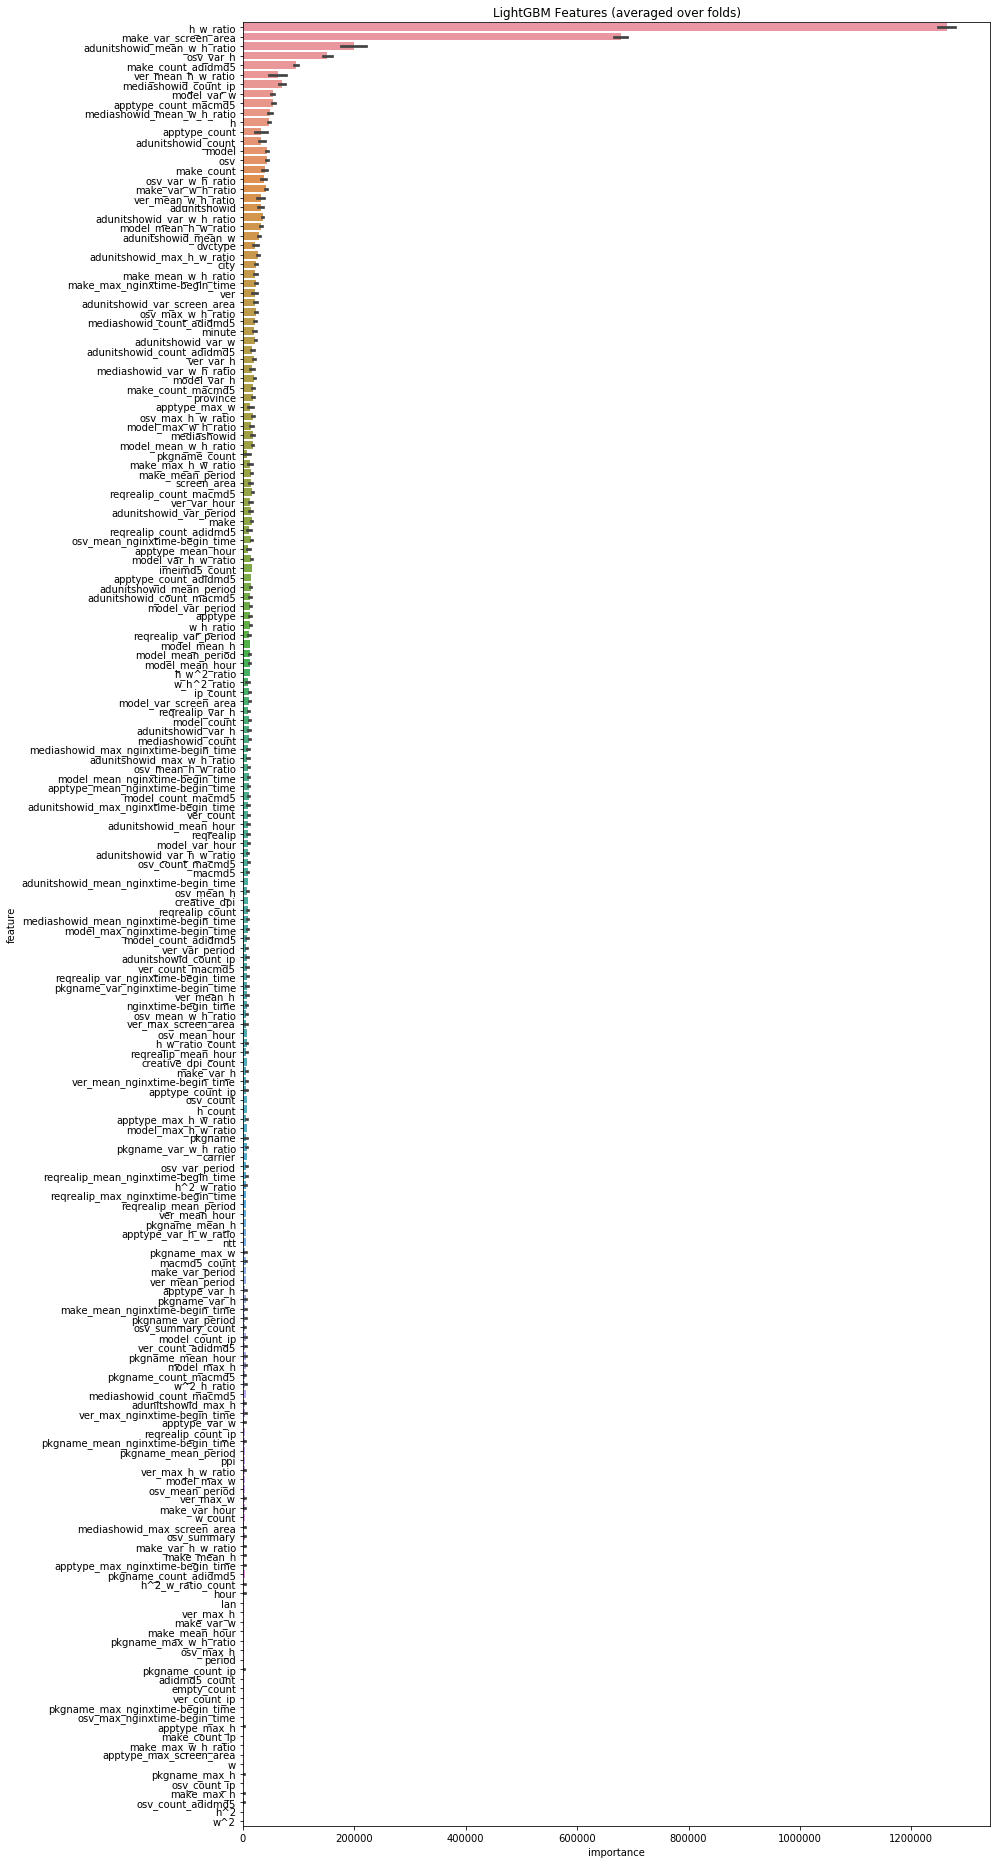

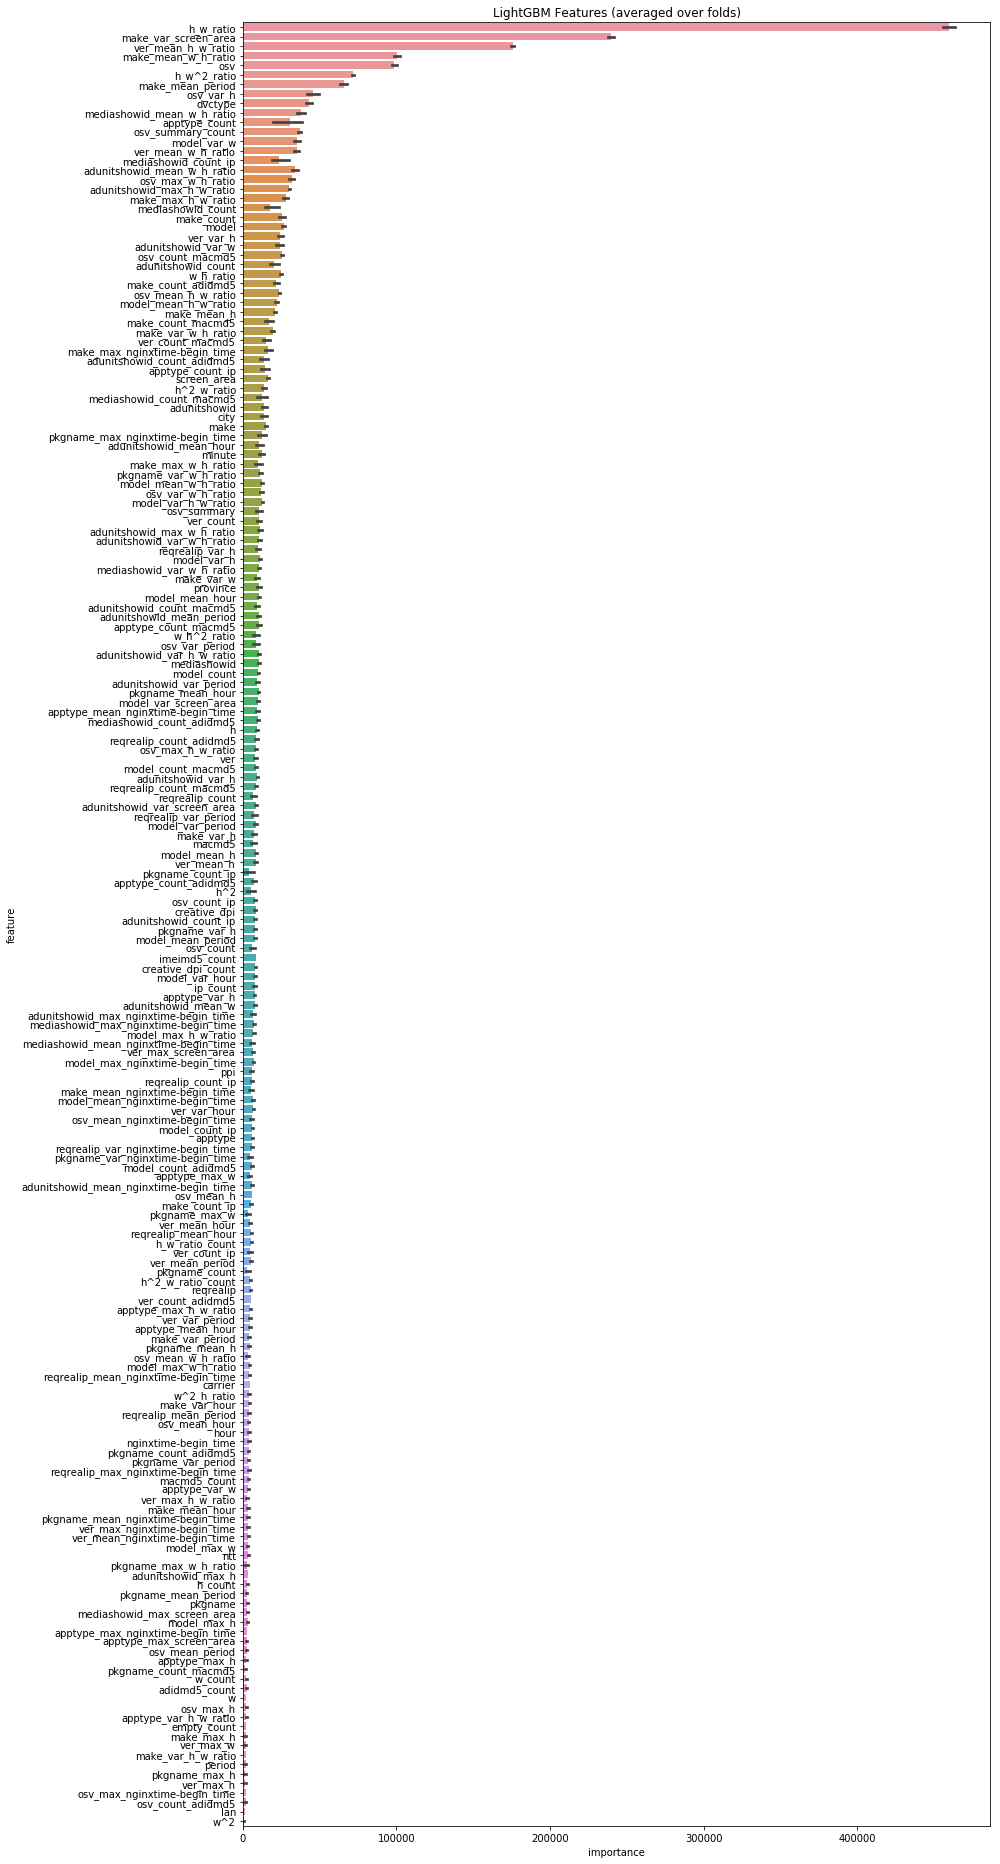

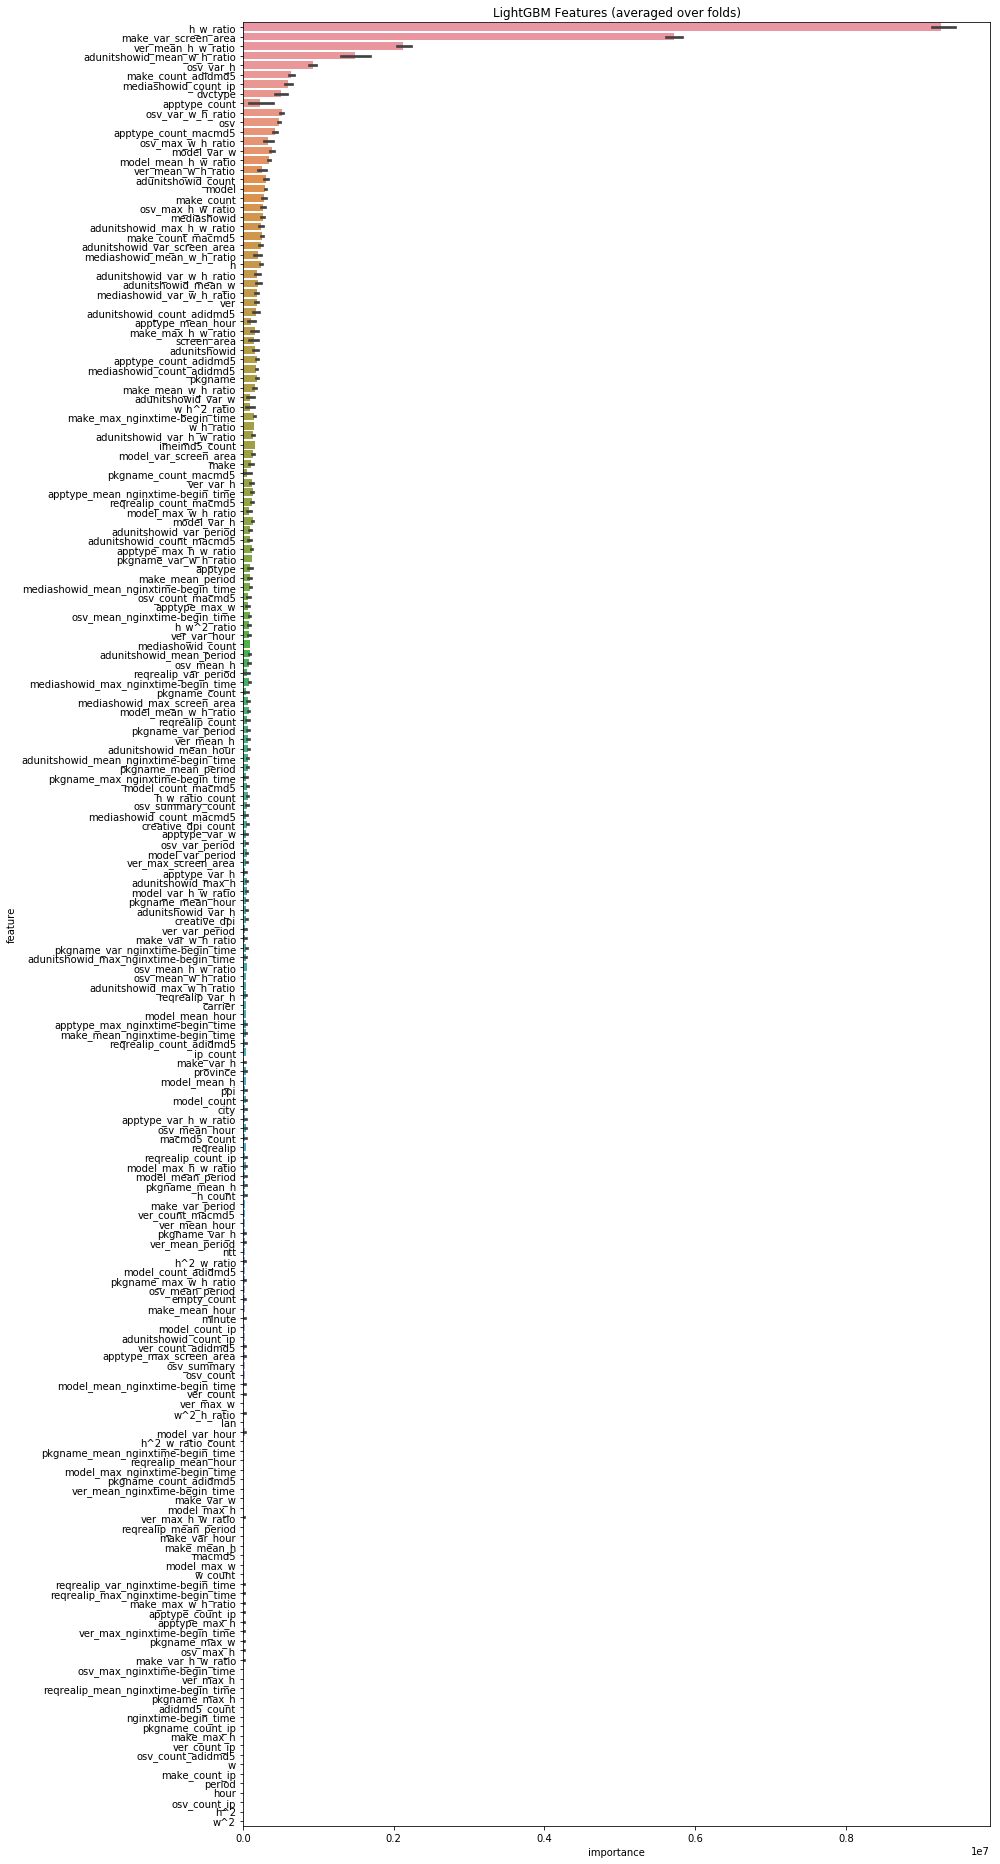

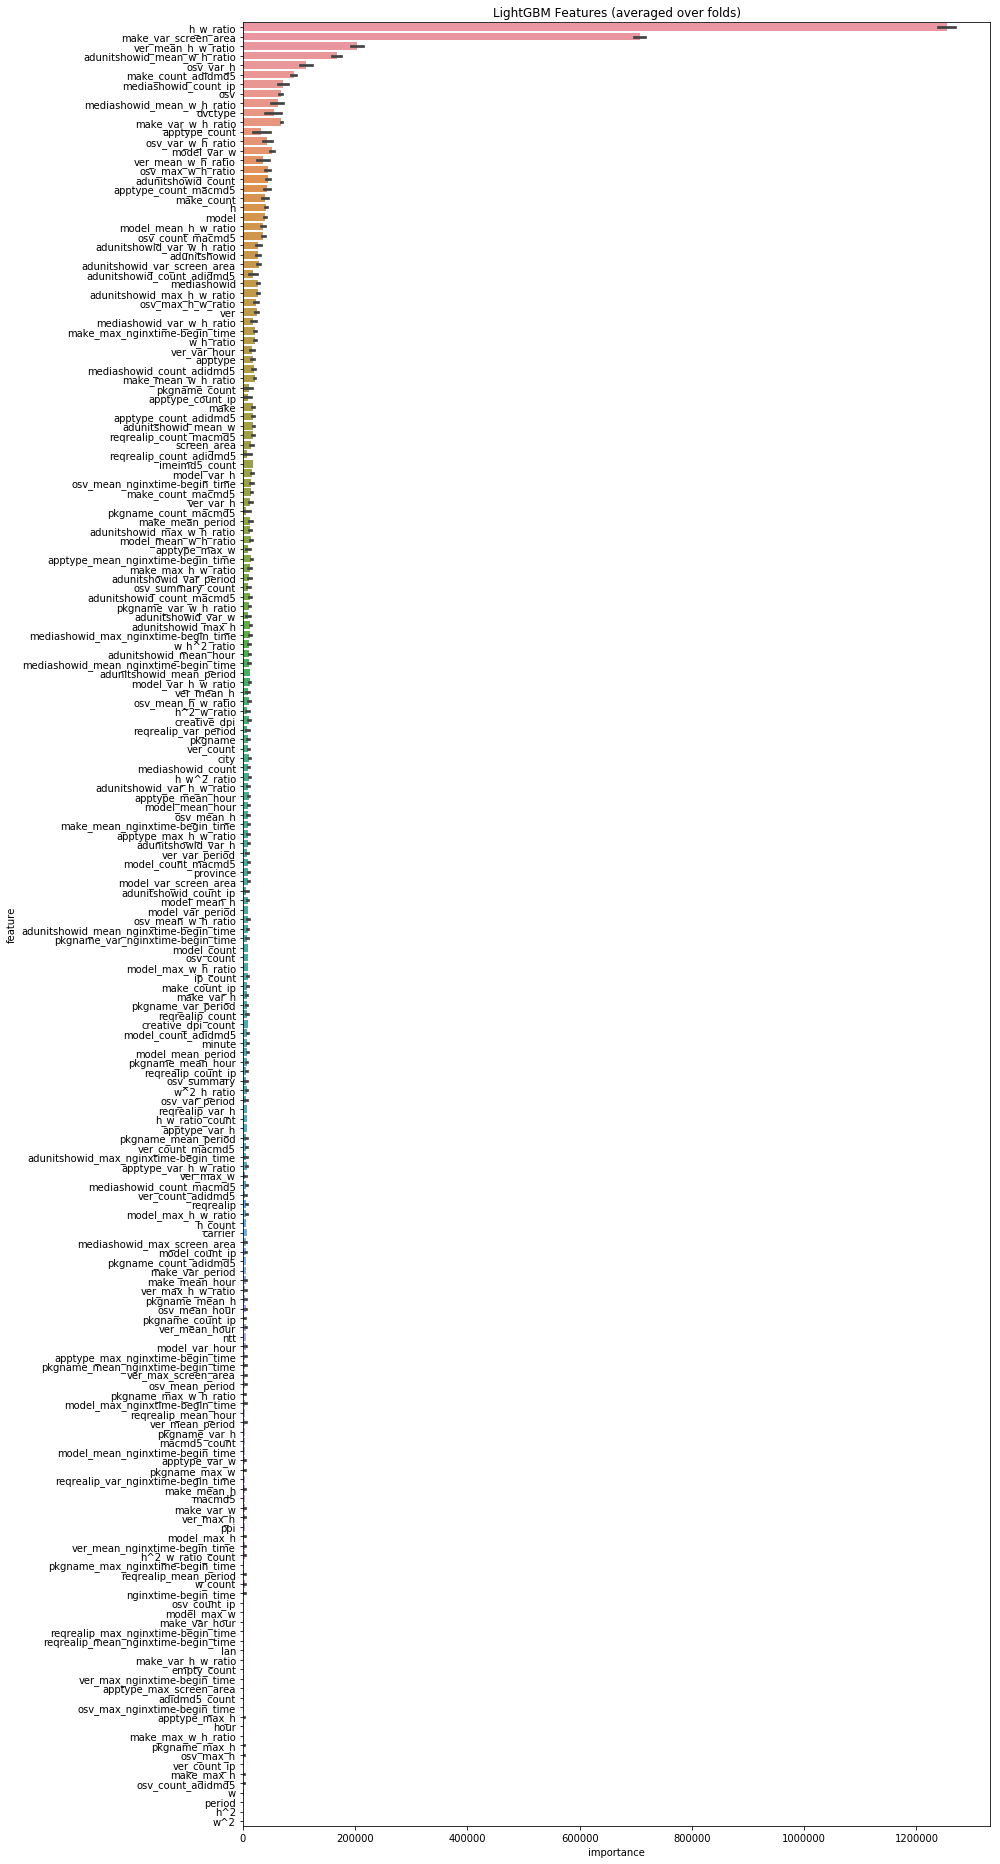

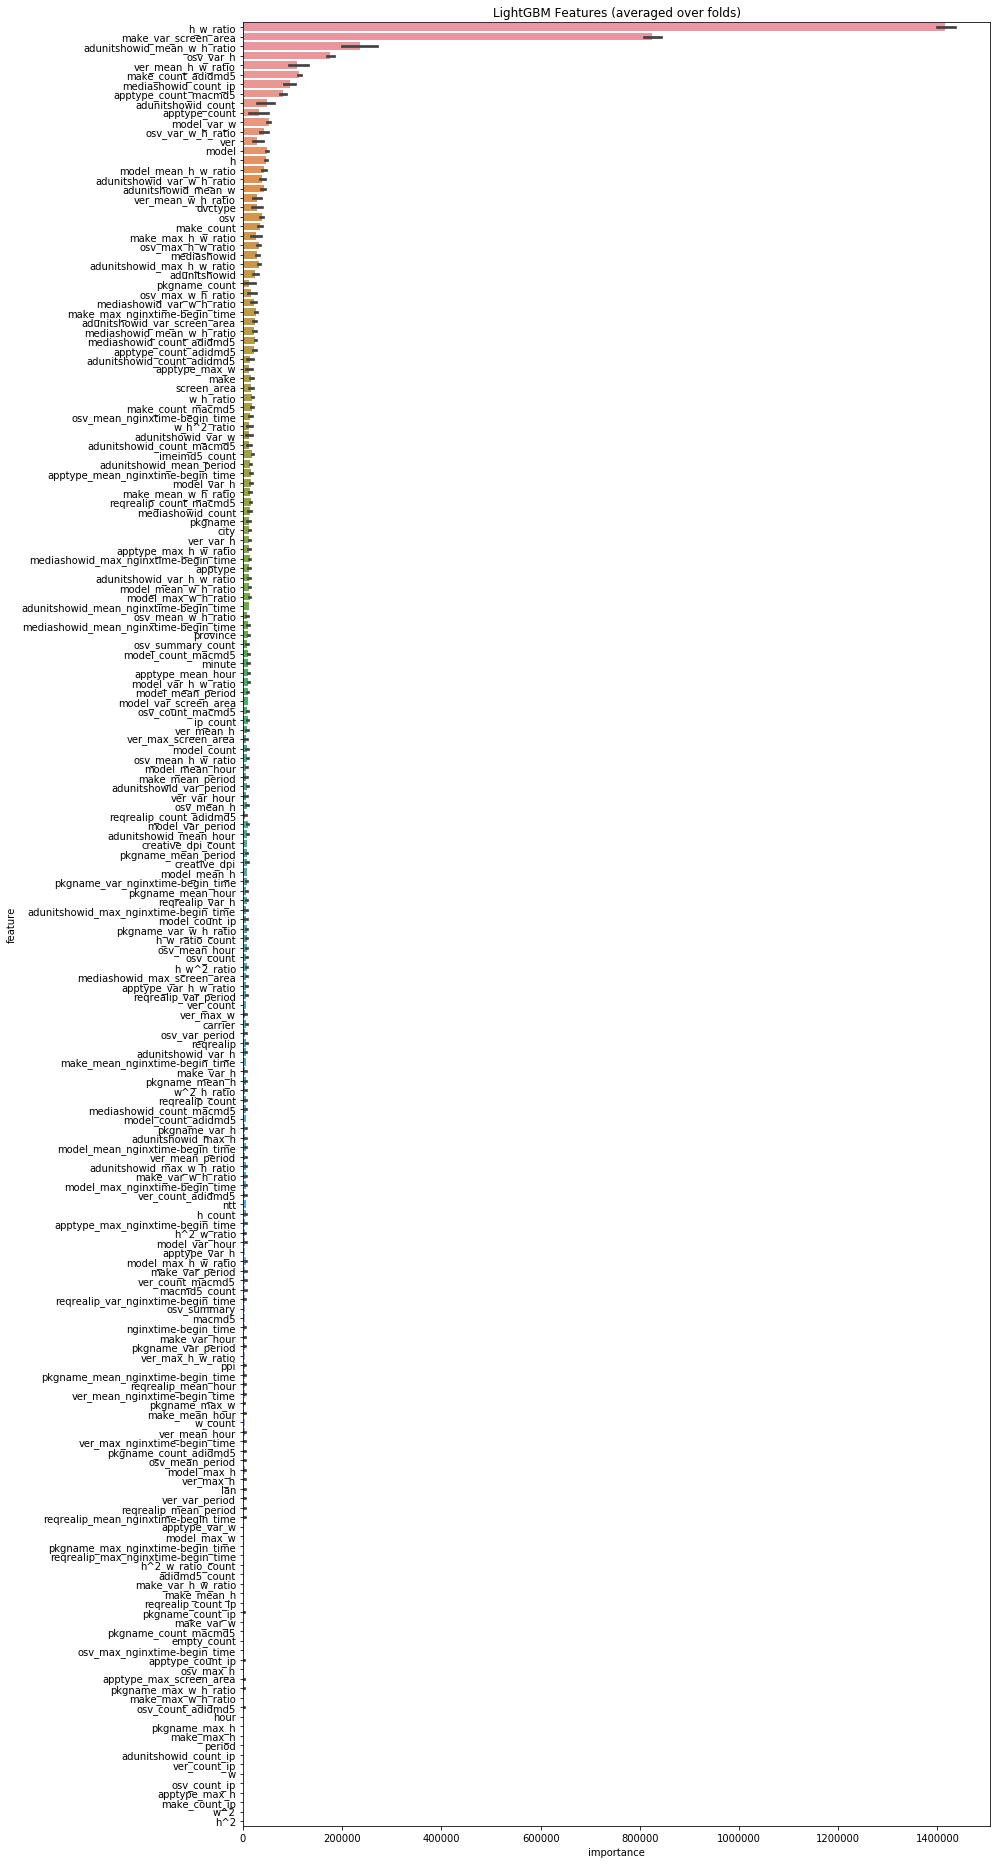

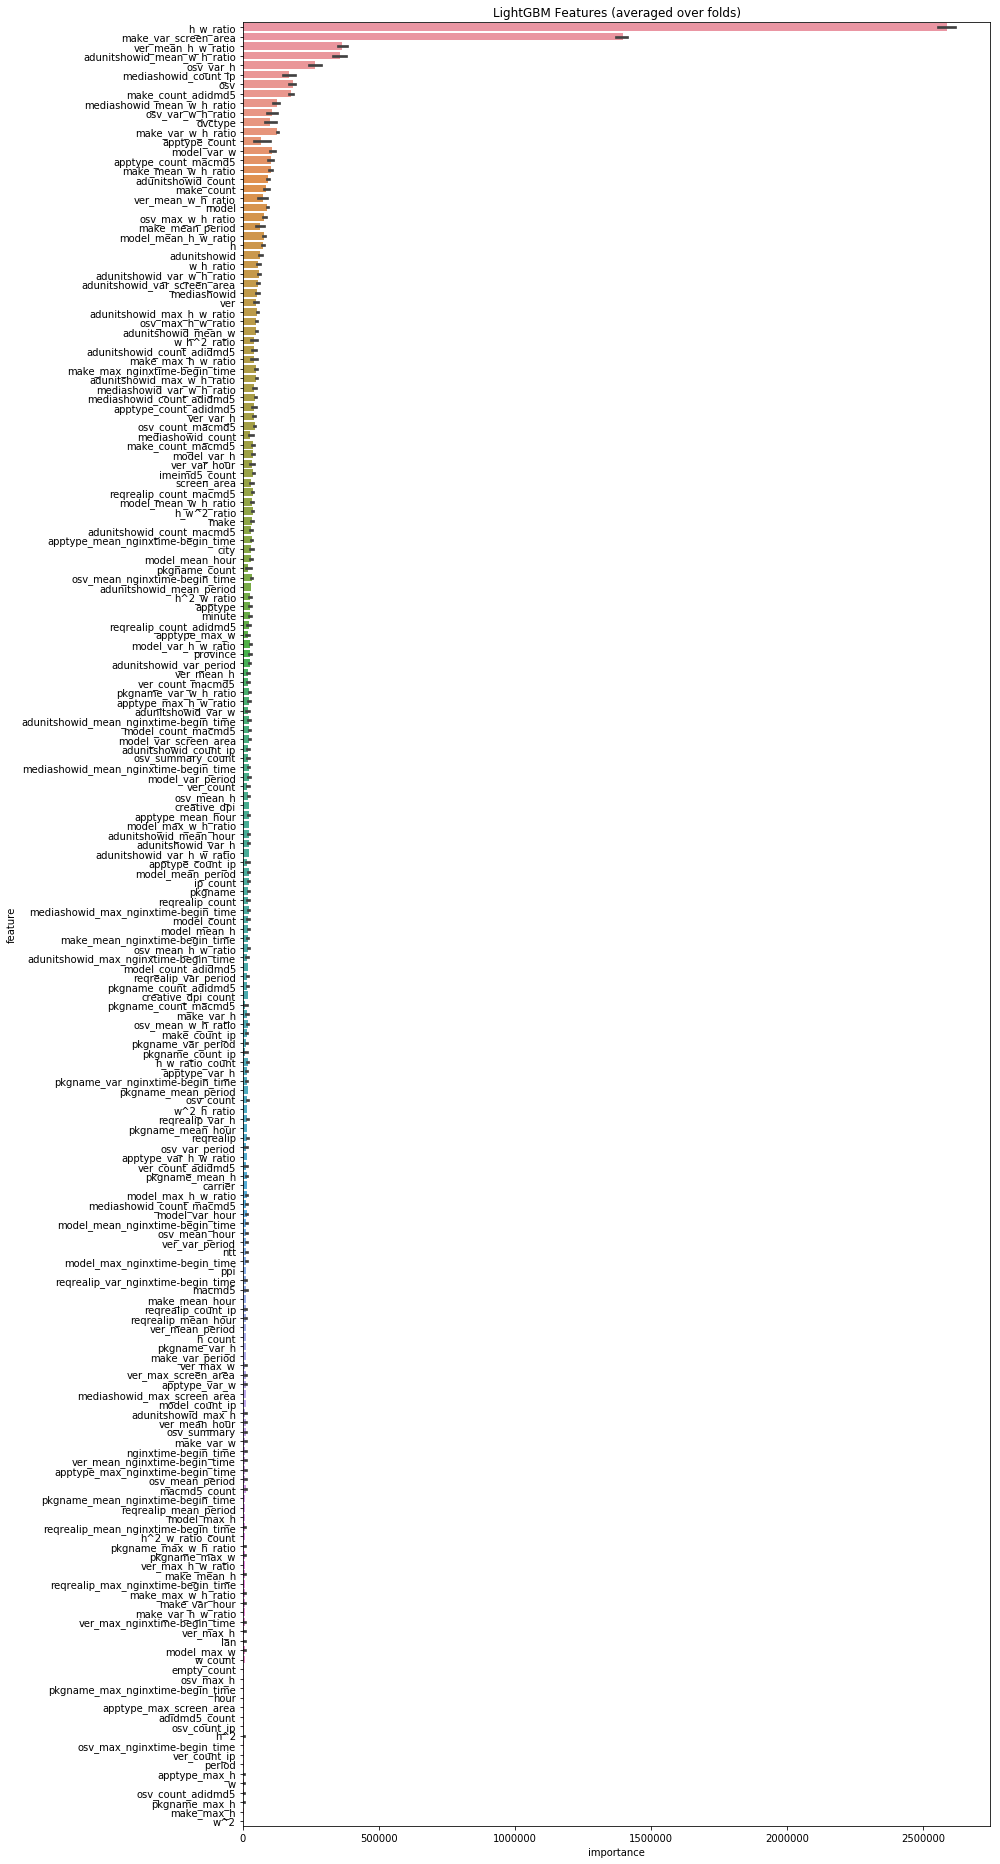

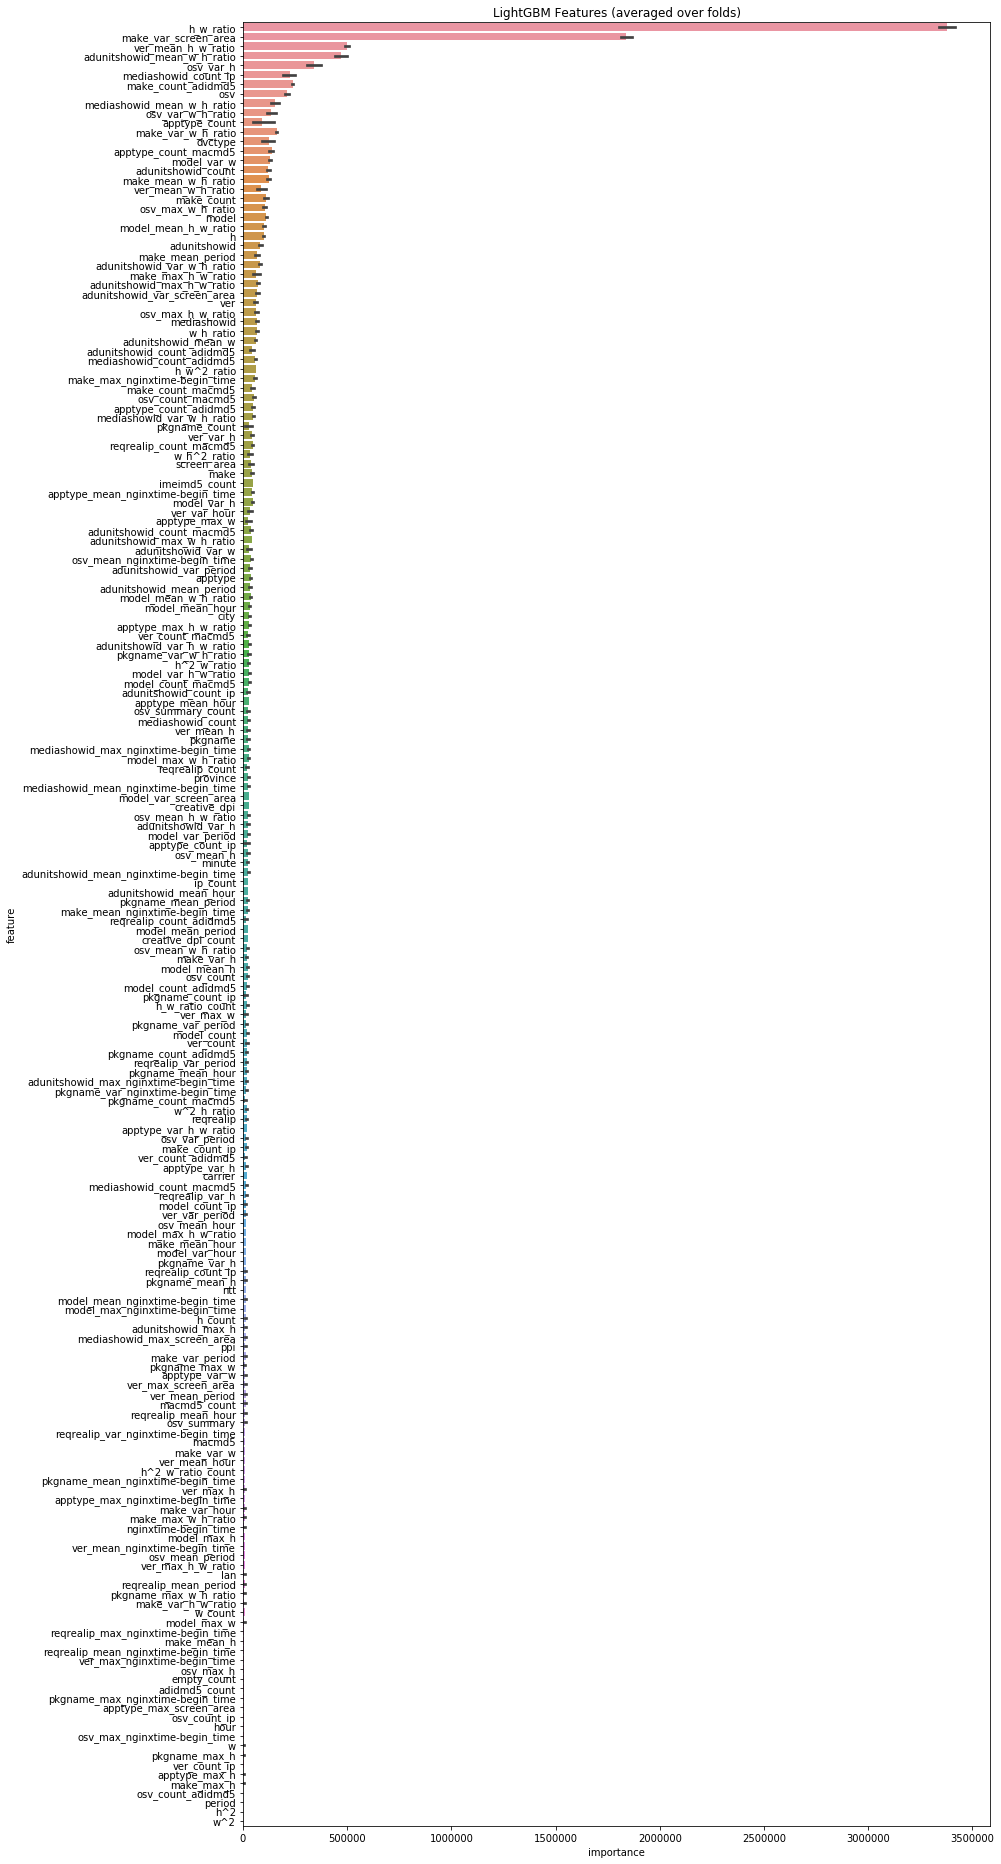

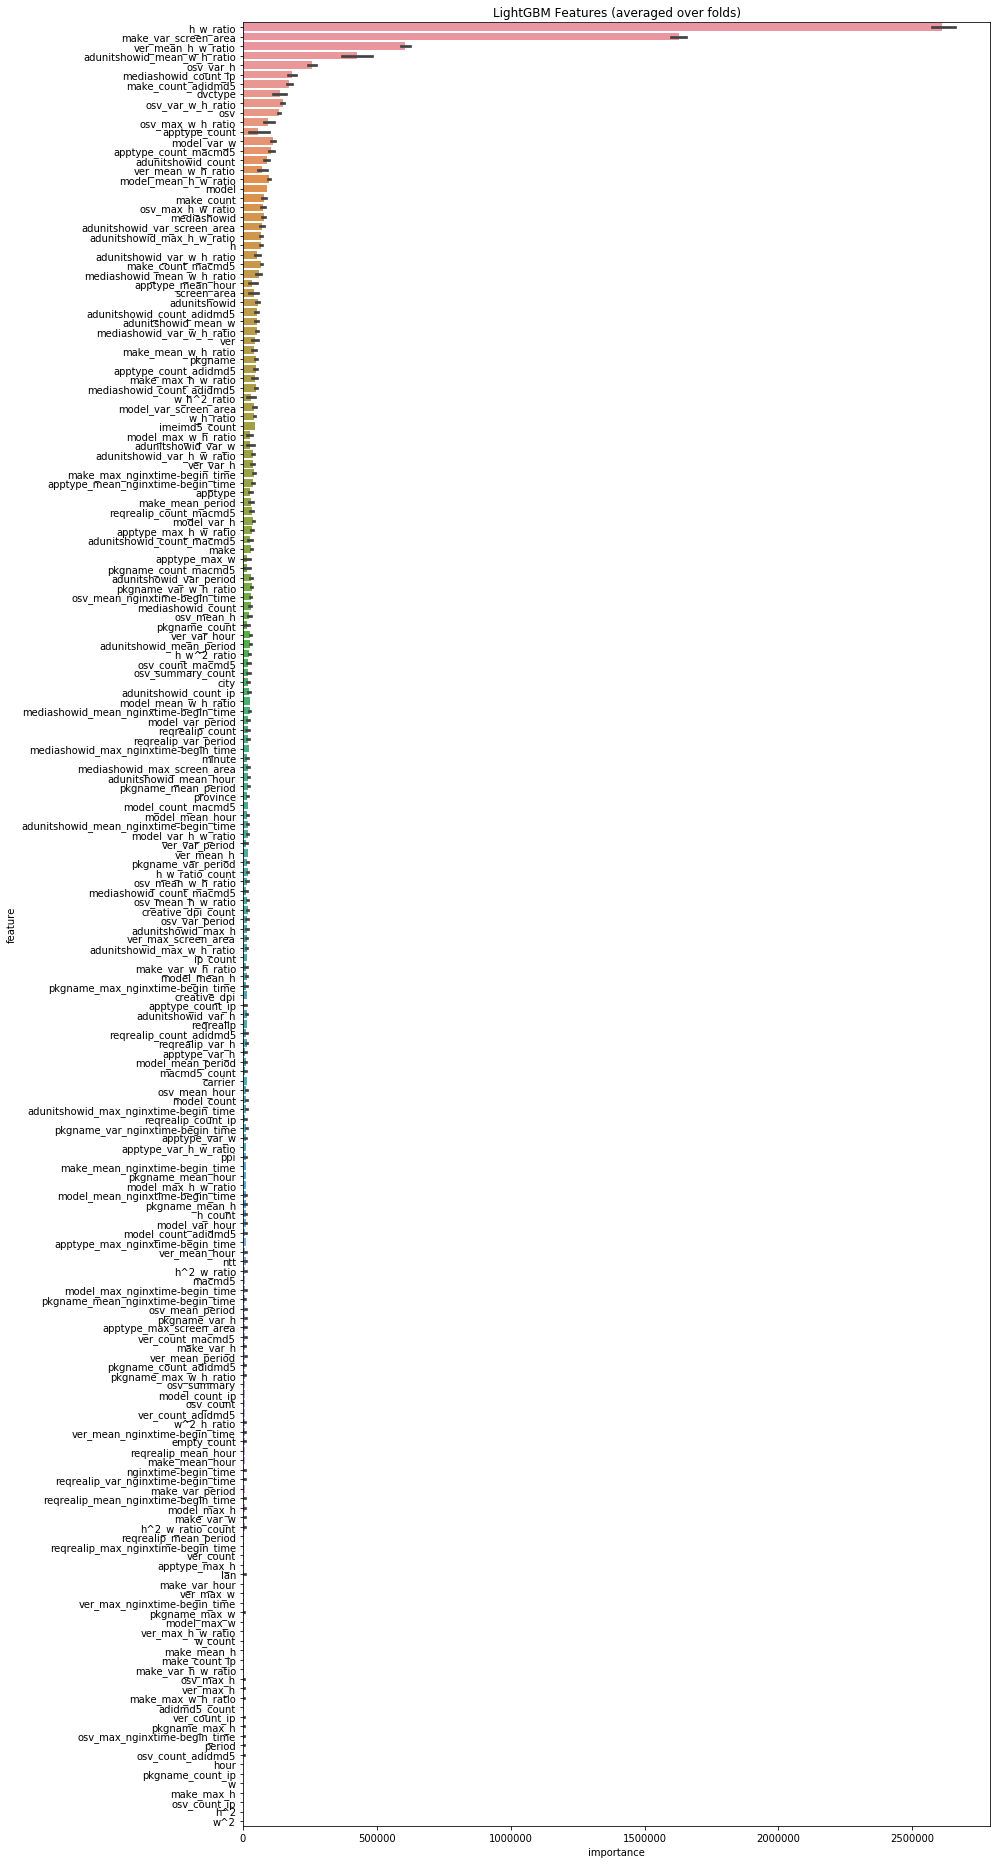

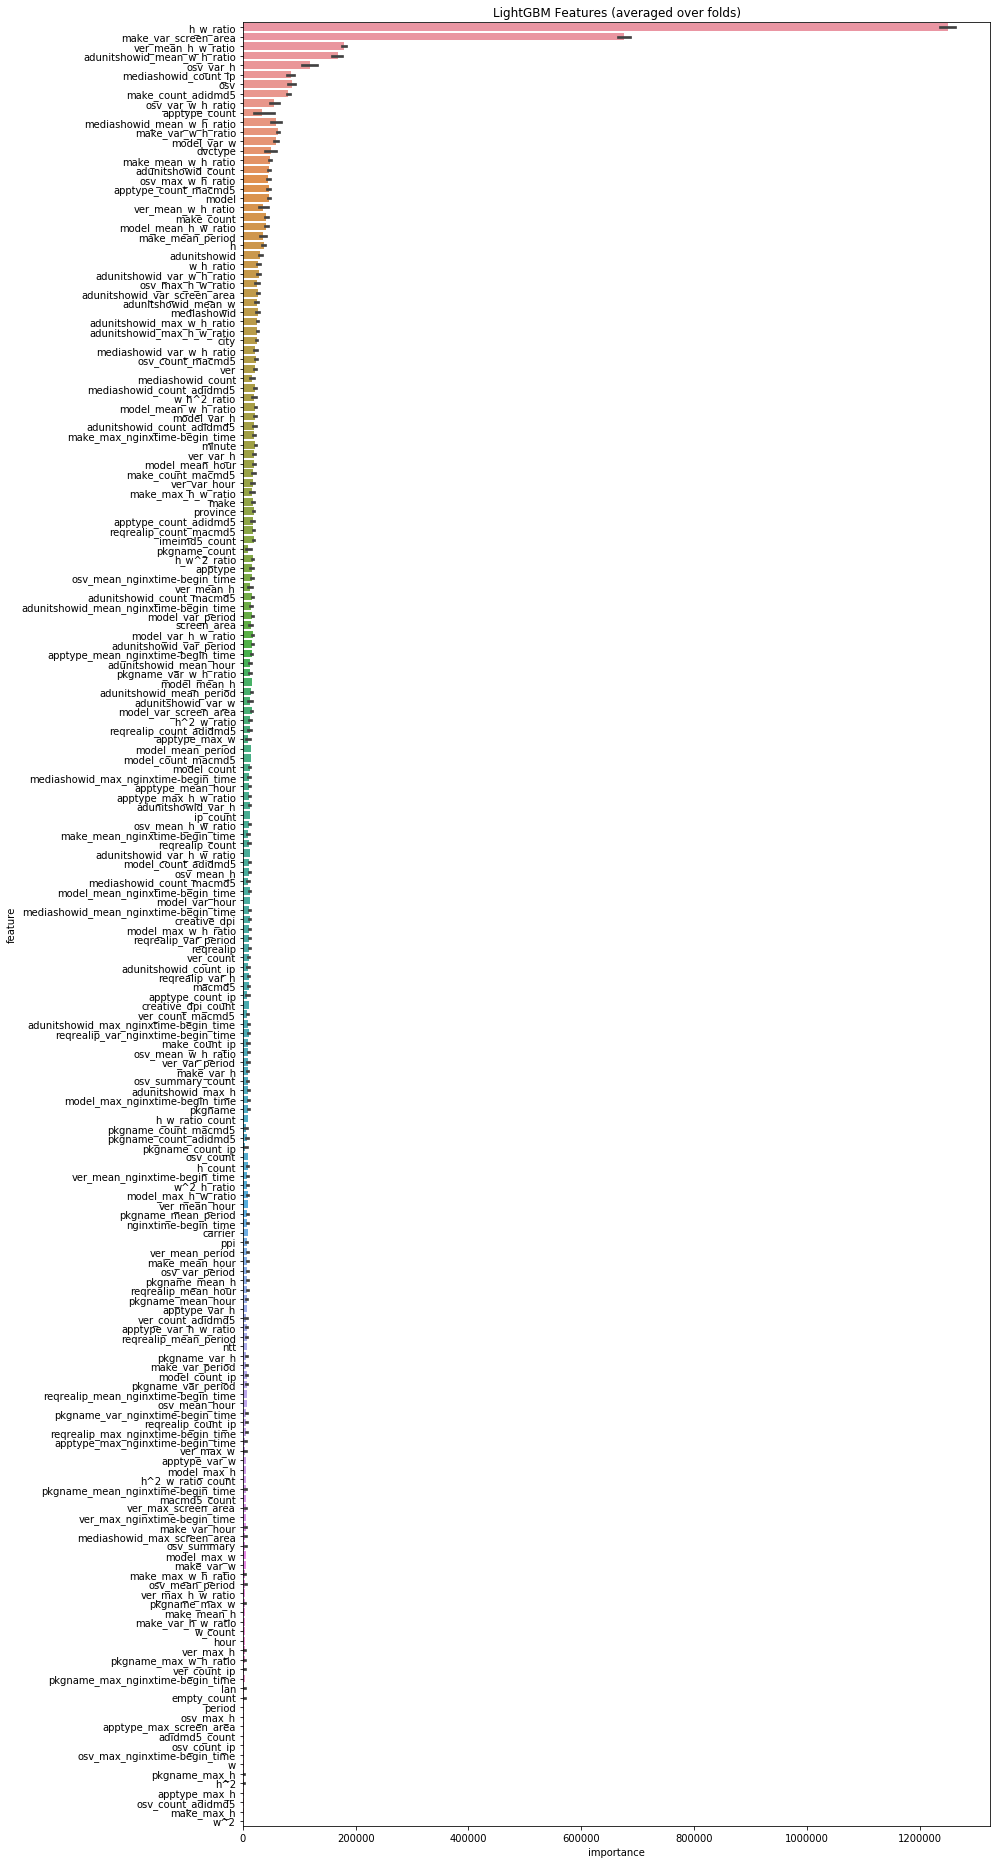

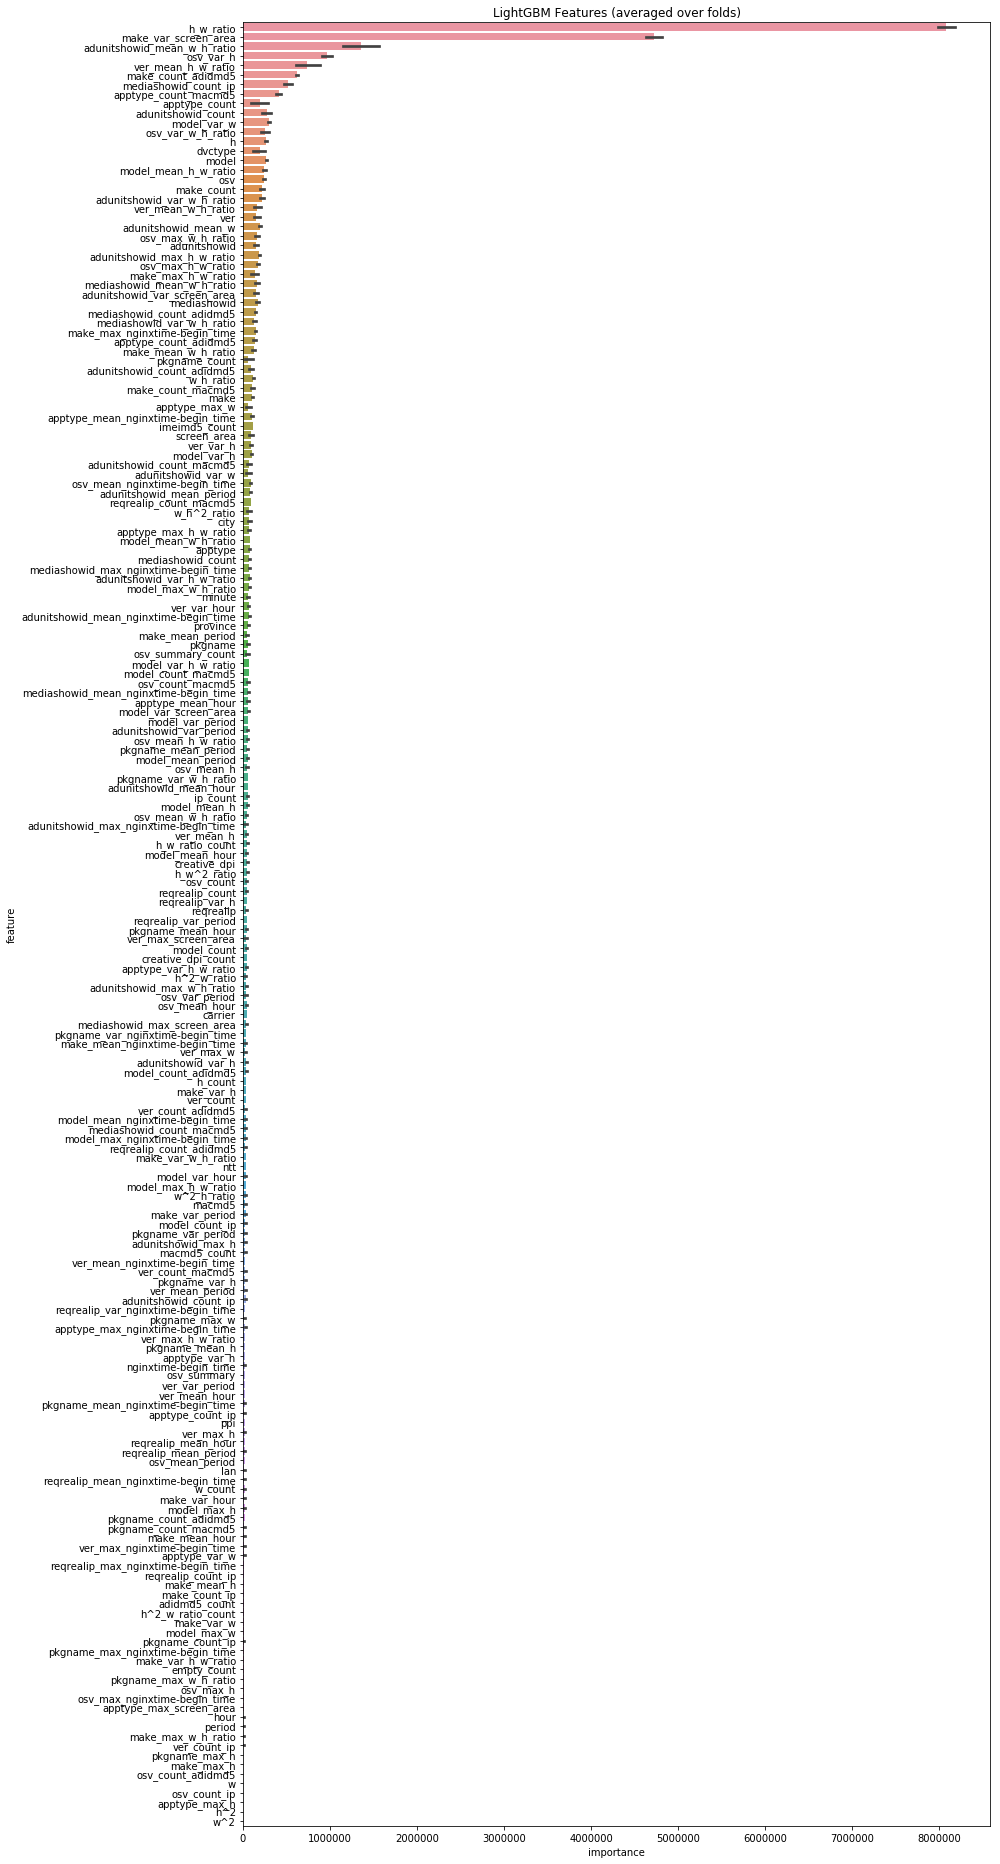

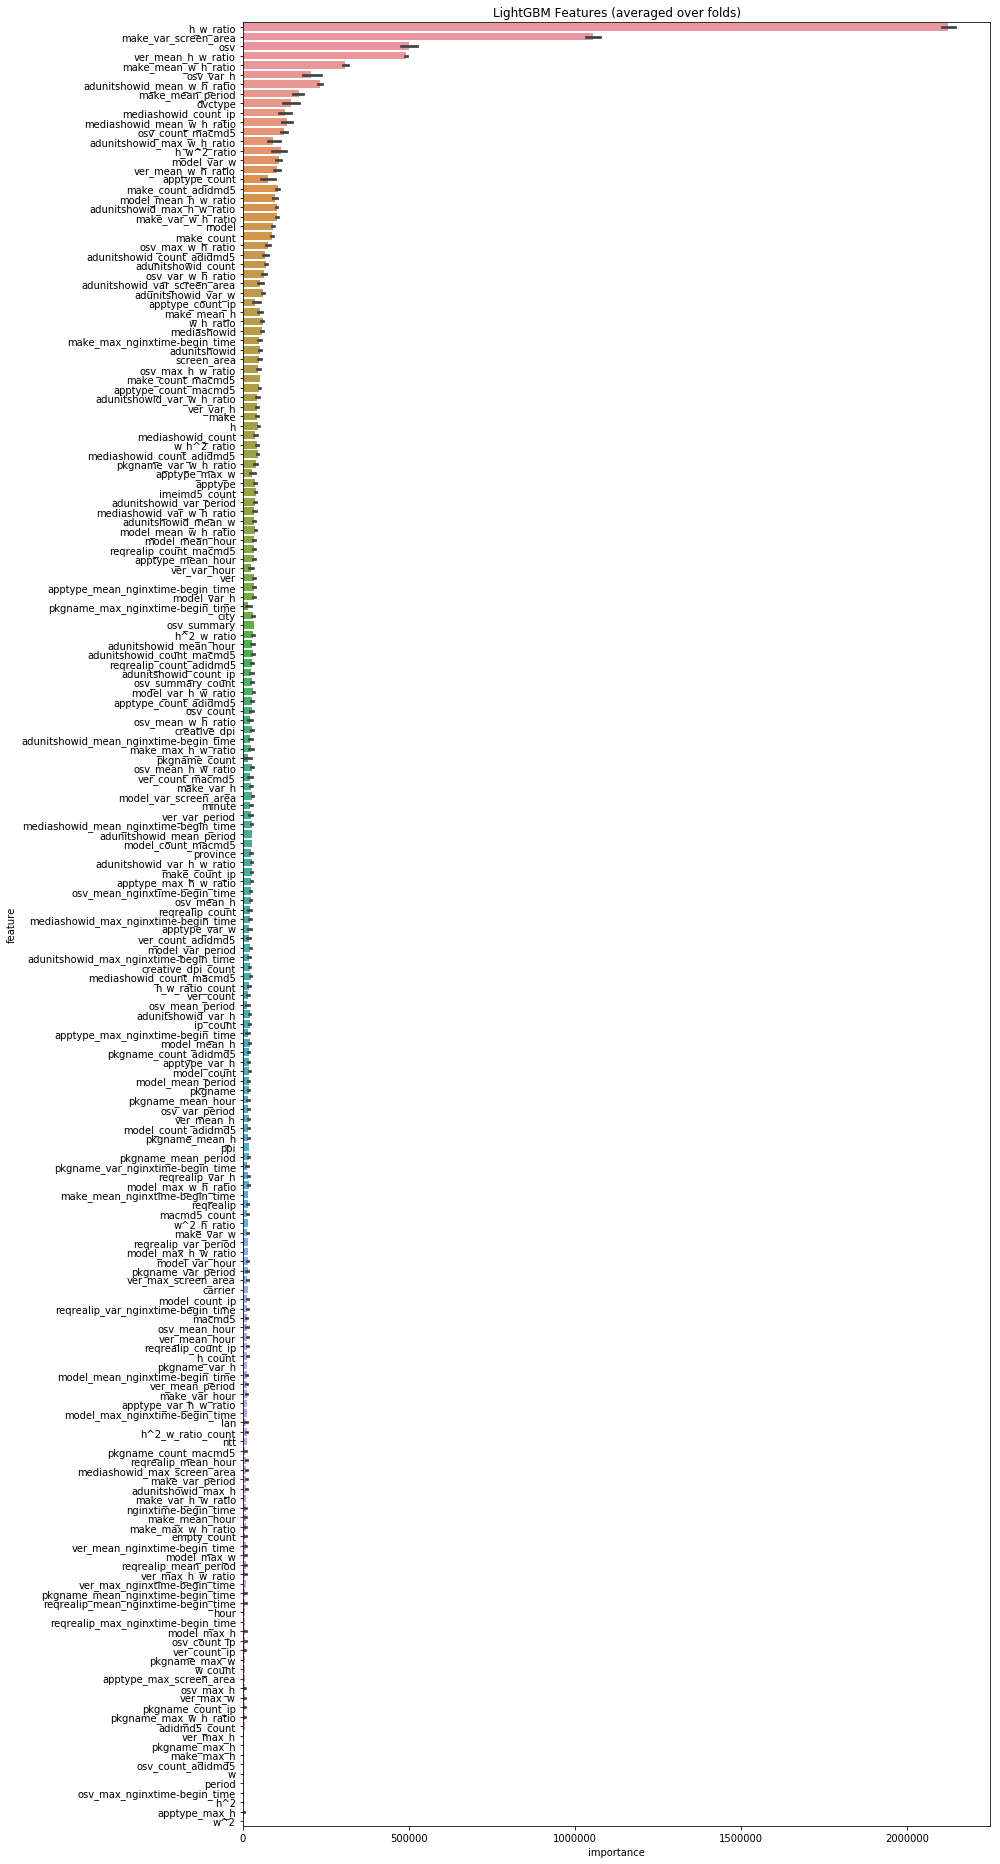

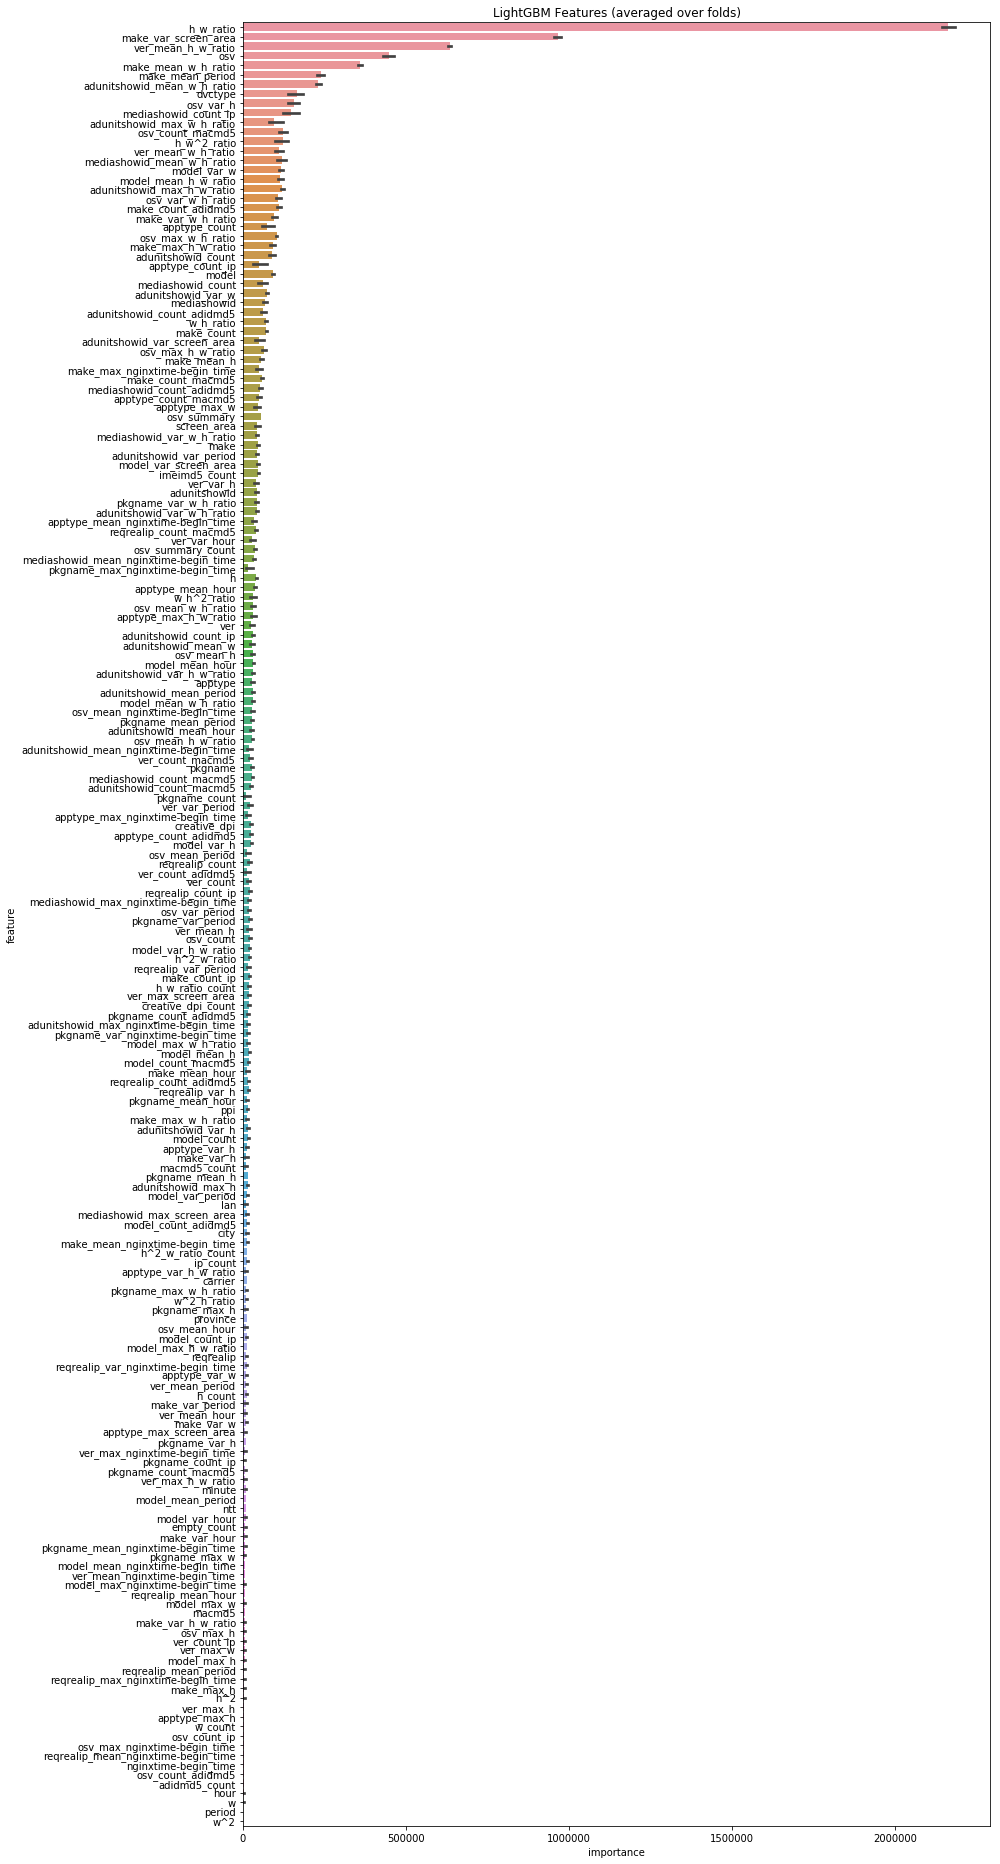

In [10]:
trials = Trials()
# 30 次搜索，大概6个小时（要看特征多少和性能
%time best = fmin(fn=lgb_cv_wrapper, space=space, algo=tpe.suggest, max_evals=30, trials=trials)
print(best)

In [ ]:
for trial in trials.trials:
    print(trial)

In [ ]:
# 直接运行kfold生成结果文件
result_df = pd.DataFrame() 
result_df['sid'] = test['sid'].tolist()
result_df['label'] = test_pred
result_df['label'] = result_df['label'].apply(lambda x: 1 if x>=0.5 else 0)
lct = time.localtime()
result_df.to_csv('submit/submit_{0}-{1}-{2}-{3}-{4}.csv'.format(lct.tm_year,lct.tm_mon,lct.tm_mday,lct.tm_hour,lct.tm_min),index=None)
result_df['label'].value_counts()